## <center><font color=navy>Algorithmic Trading with Python</font></center>
### <center>Time Series Forecasting</center>
#### <center>Ali Habibnia</center>

在本笔记本中，我们深入探讨利用Python生态系统中可用的主要工具来预测单变量时间序列问题的方法。Python中的Pandas库提供了强大的内置时间序列数据处理能力，而Statsmodels模块则为用户提供了分析数据、估计统计模型和执行统计测试的工具。

金融量化研究人员旨在通过应用统计时间序列技术来识别历史金融数据集中的趋势、季节性波动和依赖关系。最终的目标是生成可操作的交易信号。提高我们交易算法的盈利能力需要利用严格的统计方法来识别一致的资产行为，这可以被用来寻找盈利机会。这涉及对资产价格特性的时间演变进行深入分析。

首先，我们将从Yahoo Finance获取标准普尔500指数（^GSPC）数据集。在本笔记本中，我们的主要目标是对标准普尔500指数进行预测。

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import warnings
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.stats as sms
import scipy.stats as scs
from statsmodels.tsa.stattools import coint, adfuller
warnings.filterwarnings('ignore')

In [117]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import AutoReg

In [6]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## Data Preparation

### 加载和探索时间序列数据

In [7]:
# load dataset
start = datetime.datetime(2016,1,1)
end = datetime.datetime(2022,12,30)
df = yf.download("^GSPC", start=start, end=end)['Adj Close']
df.columns = [col[0] for col in df.columns]

[*********************100%***********************]  1 of 1 completed


In [8]:
# display first few lines of a time series
df.head()

Date
2016-01-04   2012.66
2016-01-05   2016.71
2016-01-06   1990.26
2016-01-07   1943.09
2016-01-08   1922.03
Name: Adj Close, dtype: float64

In [9]:
# Remove days (rows) with missing values
df.dropna(axis='index', how='all', inplace=True)

In [10]:
# the index is in datetime format, which is fine
df.index[:5]

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [20]:
Re = np.log(df).diff().dropna() # Re = np.log(df / df.shift(1))

Re.head()

Date
2016-01-05    0.00
2016-01-06   -0.01
2016-01-07   -0.02
2016-01-08   -0.01
2016-01-11    0.00
Name: Adj Close, dtype: float64

### 创建时间序列

Pandas将时间序列数据集表示为Series。Series是一种一维数组，每一行都有一个时间标签。

In [21]:
# create a time series
ts = pd.Series(df, index=df.index)
print(ts)

Date
2016-01-04   2012.66
2016-01-05   2016.71
2016-01-06   1990.26
2016-01-07   1943.09
2016-01-08   1922.03
               ...  
2022-12-22   3822.39
2022-12-23   3844.82
2022-12-27   3829.25
2022-12-28   3783.22
2022-12-29   3849.28
Name: Adj Close, Length: 1761, dtype: float64


In [23]:
# query a dataset using a date-time index
df[:'2017'].tail(10)

Date
2017-12-15   2675.81
2017-12-18   2690.16
2017-12-19   2681.47
2017-12-20   2679.25
2017-12-21   2684.57
2017-12-22   2683.34
2017-12-26   2680.50
2017-12-27   2682.62
2017-12-28   2687.54
2017-12-29   2673.61
Name: Adj Close, dtype: float64

In [24]:
# query a dataset using a date-time index
df['2020-06':'2020-07']

Date
2020-06-01   3055.73
2020-06-02   3080.82
2020-06-03   3122.87
2020-06-04   3112.35
2020-06-05   3193.93
               ...  
2020-07-27   3239.41
2020-07-28   3218.44
2020-07-29   3258.44
2020-07-30   3246.22
2020-07-31   3271.12
Name: Adj Close, Length: 44, dtype: float64

In [25]:
# summarize the dimensions of a time series
df.size

1761

In [26]:
# calculate descriptive statistics
df.describe()

count   1761.00
mean    3112.97
std      784.31
min     1829.08
25%     2488.11
50%     2888.32
75%     3819.72
max     4796.56
Name: Adj Close, dtype: float64

### 基本特征工程

在开始使用机器学习算法之前，时间序列数据必须重新构建为监督学习数据集。时间序列中没有输入和输出特征的概念。相反，我们必须选择要预测的变量，并使用特征工程构建所有将用于对未来时间步进行预测的输入。

时间序列数据集必须转换为可以建模为监督学习问题的形式。我们需要将看起来像这样的数据：

时间 1，值 1

时间 2，值 2

时间 3，值 3

转换为看起来像这样的数据：

输入 1，输出 1

输入 2，输出 2

输入 3，输出 3

### 滞后特征

滞后特征是将时间序列预测问题转换为监督学习问题的经典方法。最简单的方法是根据当前时间（t）的值预测下一个时间（t+1）的值。具有偏移值的监督学习问题如下所示：

值(t)，值(t+1)

值(t)，值(t+1)

值(t)，值(t+1)

In [27]:
values = pd.DataFrame(df.values)
df2 = pd.concat([values.shift(2), values.shift(1), values], axis=1)
df2.columns = ['t-2','t-1', 't']

In [28]:
df2.head()

,t-2,t-1,t
0,NaN,NaN,2012.66
1,NaN,2012.66,2016.71
2,2012.66,2016.71,1990.26
3,2016.71,1990.26,1943.09
4,1990.26,1943.09,1922.03


### 滚动窗口统计

在添加原始滞后值的基础上，进一步的步骤是添加之前时间步的值的汇总。我们可以计算滑动窗口内值的汇总统计，并将这些作为特征包含在我们的数据集中。也许最有用的是之前值的均值，也称为滚动均值。

In [30]:
values = pd.DataFrame(df.values)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

df3 = pd.concat([means, values], axis=1)
df3.columns = ['mean(t-2,t-1)', 't']
df3.head()

,"mean(t-2,t-1)",t
0,NaN,2012.66
1,NaN,2016.71
2,2014.68,1990.26
3,2003.48,1943.09
4,1966.67,1922.03


### 扩展窗口统计

另一种可能有用的窗口类型是包含序列中所有先前数据的窗口。这被称为扩展窗口，可以帮助跟踪可观察数据的范围。

In [31]:
values = pd.DataFrame(df.values)
window = values.expanding()

df4 = pd.concat([window.mean(), values], axis=1)
df4.columns = ['mean', 't']
df4.head()

,mean,t
0,2012.66,2012.66
1,2014.68,2016.71
2,2006.54,1990.26
3,1990.68,1943.09
4,1976.95,1922.03


## 数据可视化

时间序列自然适合可视化。随时间变化的观察值的折线图很受欢迎，但还有一系列其他图表可以帮助你更深入地了解问题。你对数据了解得越多，就越有可能开发出更好的预测模型。

<AxesSubplot:xlabel='Date'>

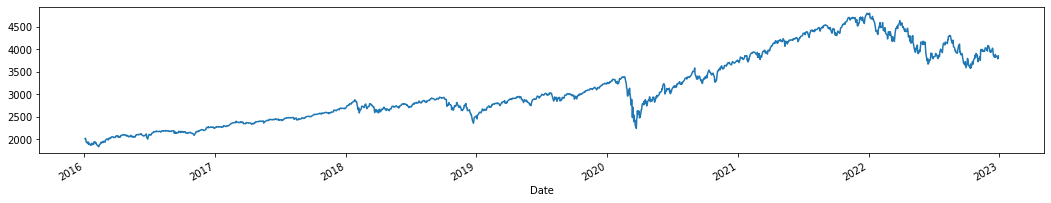

In [32]:
# Line Plot
df.plot()

<AxesSubplot:xlabel='Date'>

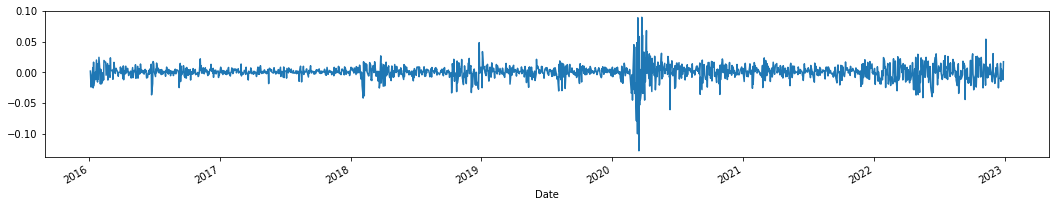

In [34]:
Re.plot()

<AxesSubplot:>

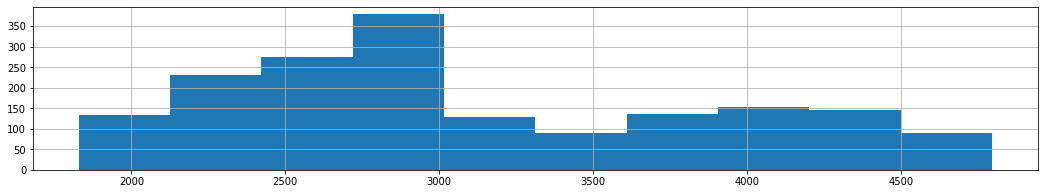

In [35]:
# Histogram and Density Plots
df.hist()

<AxesSubplot:>

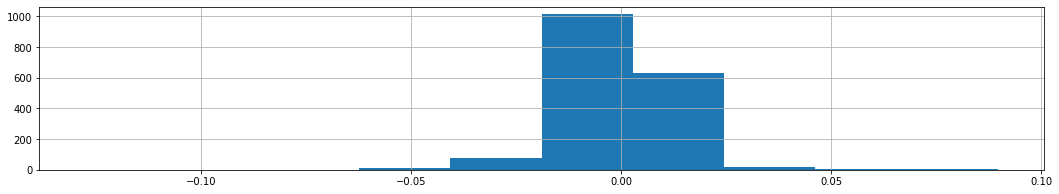

In [36]:
Re.hist()

这意味着绘制值时不考虑时间顺序。一些线性时间序列预测方法假设观察值具有良好的分布（即钟形曲线或正态分布）。可以使用统计假设检验等工具明确检查这一点。但图表可以为原始观察值及任何数据转换后观察值的分布提供有用的初步检查。

<AxesSubplot:ylabel='Density'>

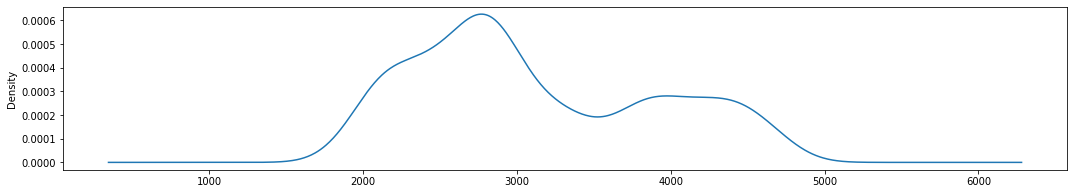

In [39]:
df.plot(kind='kde')

核密度估计（KDE）：KDE的主要目的是提供直方图的平滑版本，显示数据的一般分布。对于时间序列数据，这有助于理解序列所取值的分布情况，无论是正态分布、偏斜分布等。

### 滞后散点图

时间序列建模假设观察值与之前的观察值之间存在关系。时间序列中的前一个观察值称为滞后，前一个时间步的观察值称为滞后=1，两个时间步之前的观察值称为滞后=2，以此类推。探索每个观察值与其滞后值之间关系的一种有用图表称为散点图。Pandas有一个内置函数专门用于此，称为滞后图。它在x轴上绘制时间t的观察值，在y轴上绘制滞后=1的观察值（t-1）。

- 如果点沿着从左下角到右上角的对角线聚集，说明存在正相关关系。
- 如果点沿着从左上角到右下角的对角线聚集，说明存在负相关关系。
- 这两种关系都是好的，因为它们可以被建模。

越多的点紧密地靠近对角线，表明关系越强；而越远离对角线则表明关系越弱。图中间的点或分散的点则表明关系较弱或没有关系。

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

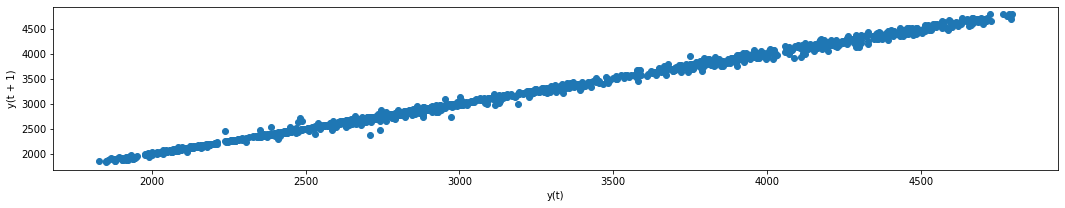

In [40]:
lag_plot(ts)

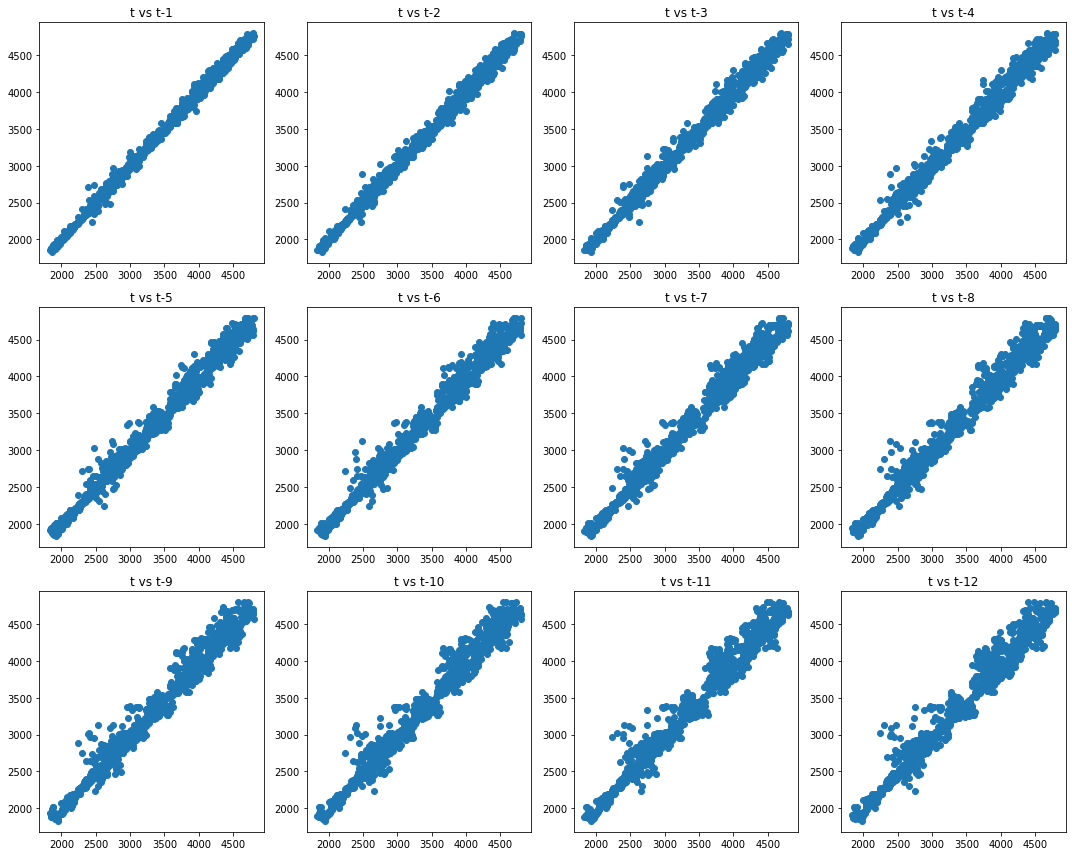

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create multiple scatter plots
values = pd.DataFrame(df.values)
lags = 12
columns = [values]

for i in range(1, (lags + 1)):
    columns.append(values.shift(i))

dff = pd.concat(columns, axis=1)

# Rename the first column as 't'
columns = ['t']
for i in range(1, (lags + 1)):
    columns.append('t-' + str(i))

dff.columns = columns

# Using GridSpec for dynamic subplot arrangement
rows = (lags + 3) // 4  # Dynamically calculate rows based on lags
gs = gridspec.GridSpec(rows, 4)
fig = plt.figure(figsize=(15,12))

for i in range(1, (lags + 1)):
    ax = fig.add_subplot(gs[(i-1) // 4, (i-1) % 4])
    ax.set_title('t vs t-' + str(i))
    ax.scatter(x=dff['t'].values, y=dff['t-'+str(i)].values)

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

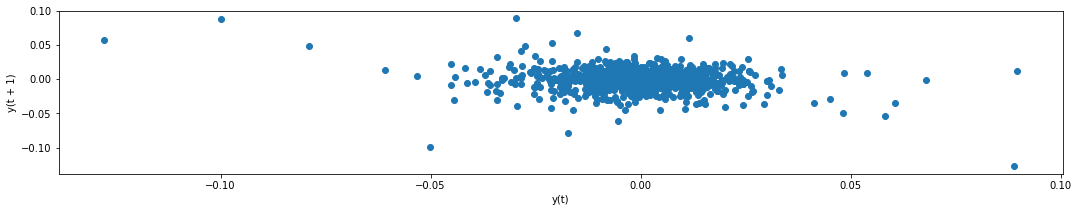

In [47]:
lag_plot(Re)

### 自相关图

自相关图，也称为相关图或自相关函数（ACF）图，用于可视化一个序列与其自身滞后值之间的相关性。当应用于金融价格序列或其他领域时，它可以提供以下方面的洞察：

1. **趋势**：如果价格序列具有强趋势，前几个滞后的自相关值可能显著为正。这是因为在趋势序列中，连续值往往比相隔较远的值更接近。

2. **季节性**：自相关函数中规律的波动模式可以暗示价格序列中的季节性。如果存在一致的模式（例如，每12个滞后出现一个峰值），这可能表明如果数据是按月记录的，则存在年度季节性效应。

3. **均值回归**：对于股票价格等金融价格序列，如果在第一个或第二个滞后处存在负自相关，这可能表明均值回归过程。这可能意味着向上的波动通常会被向下的波动所跟随，反之亦然。这在配对交易等策略的背景下尤为相关。

4. **随机游走**：如果第一个滞后（滞后1）的自相关接近零，并且所有其他自相关也非常接近零，这表明该序列可能是随机游走。对于股票价格，这种情况通常存在，序列更好地用其收益而非水平来描述。

5. **平稳性**：在少数滞后后自相关的急剧下降表明该序列可能是平稳的（或通过变换使其平稳）。另一方面，非平稳数据将显示自相关的缓慢衰减。

6. **模型识别**：在自回归（AR）和移动平均（MA）模型的背景下，自相关图可以帮助识别模型的阶数。例如，如果序列的自相关函数在`p`个滞后后截断，但偏自相关函数（PACF）逐渐衰减，则该序列可以视为AR(p)过程。

需要注意的是，解释自相关图时需要谨慎：

- 由于有效市场假说，金融价格序列通常在其水平上并不表现出显著的自相关。然而，它们的收益或变化可能会显示出模式。

- 在价格序列的收益中，前几个滞后的显著自相关可能表明动量或均值回归。

- 对于非平稳序列，自相关可能在多个滞后中保持显著，给人一种关系存在的错误印象。

在处理金融价格序列时，通常分析收益（或对数收益）的自相关，而不是价格，因为收益往往比原始价格更平稳且更易解释。

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

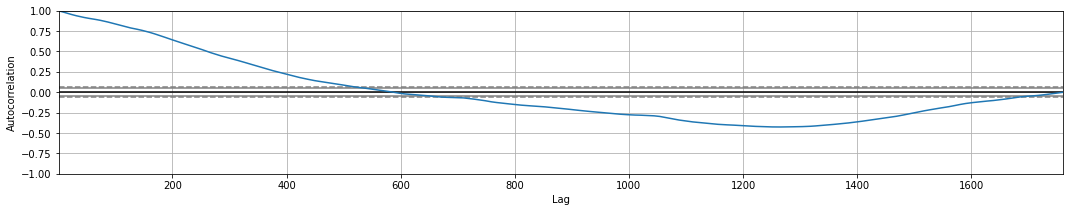

In [48]:
# create an autocorrelation plot
autocorrelation_plot(df)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

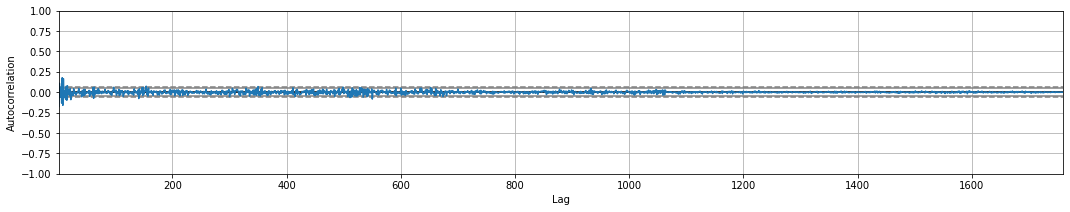

In [50]:
autocorrelation_plot(Re)

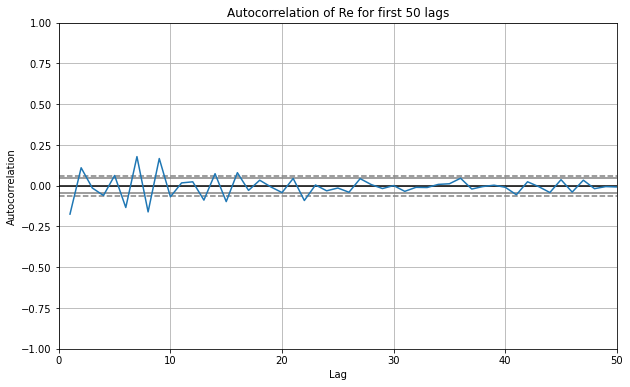

In [51]:
# Plotting the autocorrelation for the first 50 lags
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(Re)
plt.xlim([0, 50])  # Limiting the lags to 50
plt.title("Autocorrelation of Re for first 50 lags")
plt.show()


在解释金融收益的自相关图（ACF图）时，有几个关键点需要考虑：

1. **随机游走和白噪声**：对于许多金融时间序列，原始价格序列（如股票价格）通常接近于随机游走，这意味着连续值之间没有相关性。然而，当计算收益（例如，日收益）时，序列往往更像白噪声，这意味着没有可预测的模式或趋势。在理想的白噪声序列中，所有滞后大于零的自相关值接近于零。

2. **显著性水平**：自相关图通常包括表示显著性水平的水平线。如果自相关值落在这些边界内，通常被认为在统计上不显著。如果落在这些边界之外，则有证据表明收益序列并非纯随机，可能存在自相关。

3. **短期依赖性**：在某些金融收益序列中，您可能会观察到前几个滞后处的显著自相关。这可能是由于：
   - **波动聚集**：收益的大幅变化往往会跟随大幅变化（无论是正向还是负向），而小幅变化则往往会跟随小幅变化。这种现象称为波动聚集，通常在金融数据中观察到。
   - **市场反应**：有时，市场可能会对新闻或事件作出延迟反应，从而导致短期自相关。

4. **衰减模式**：自相关图中的缓慢衰减可能表明长记忆过程或移动平均（MA）过程。在金融术语中，这可能表明市场反应或趋势的持续存在。

5. **季节性效应**：如果自相关图在规律间隔处出现重复的峰值，这可能表明数据中的季节性。然而，在金融日收益中，季节性相对较少。如果数据是按月或按季度记录的，您可能会观察到由于商业周期或其他因素导致的季节性。

6. **非平稳性**：如果自相关图开始时非常高并且缓慢下降，这可能是您的序列非平稳的迹象。非平稳序列在预测中可能会带来挑战，可能需要进行差分或变换。

总之，对于金融收益，自相关图可以提供有关收益是否纯随机或是否存在潜在可利用模式的洞察。然而，必须谨慎：即使检测到模式，它们也可能不会随着时间的推移而保持一致，交易成本或其他因素可能会迅速侵蚀基于观察到的模式的策略所带来的潜在收益。

Statsmodels库还提供了一种自相关图的线图版本。该图在水平轴上绘制滞后值，在垂直轴上绘制相关性。

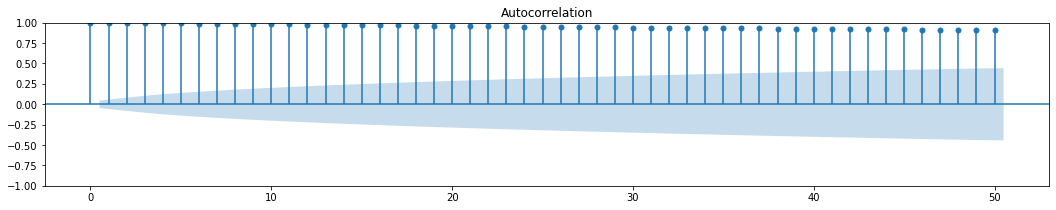

In [52]:
# autocorrelation plot of time series as a line plot
plot_acf(df, lags=50)
plt.show()

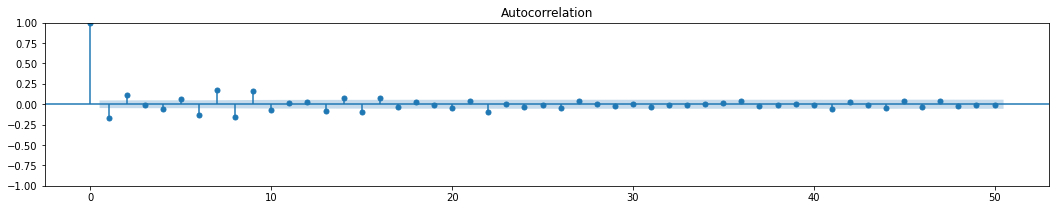

In [54]:
plot_acf(Re, lags=50)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

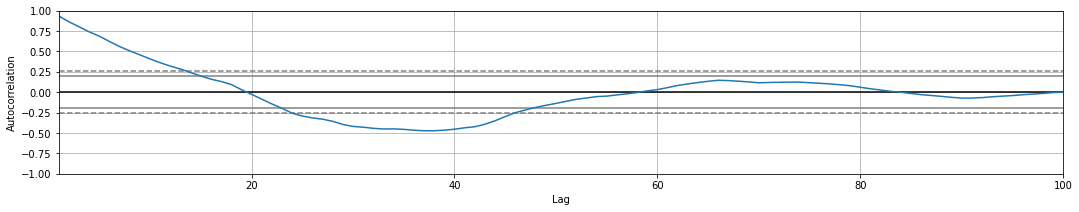

In [55]:
# create an autocorrelation plot, using only the last 100 entries
autocorrelation_plot(df[-100:])

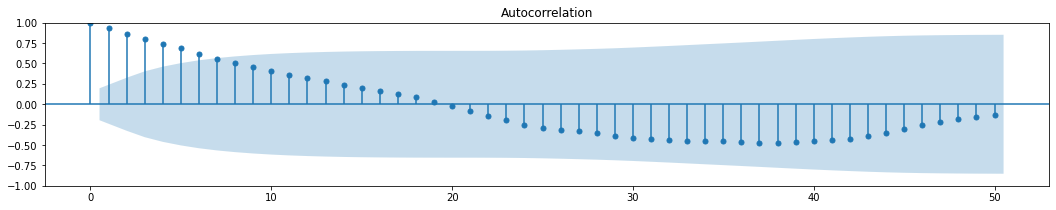

In [56]:
# autocorrelation plot of time series as a line plot
plot_acf(df[-100:], lags=50)
plt.show()

偏自相关函数（PACF）图提供了时间序列中一个观察值与之前时间步的观察值之间关系的洞察，同时去除了中间观察值的影响。

以下是如何解释PACF图：

1. **滞后值**：x轴表示滞后值。例如，滞后1表示序列与其前一个值之间的相关性。

2. **相关性**：y轴显示偏自相关的值。其范围从-1到1，类似于相关系数。接近1的值表示强正相关，接近-1的值表示强负相关，而接近0的值表示几乎没有相关性。

3. **置信区间**：PACF图通常在统计显著性点绘制水平线。这些线表示置信区间，通常设定为95%。超出这些线的相关性值被视为统计显著。

4. **显著滞后**：PACF图在上置信区间或下置信区间交叉的滞后被视为显著。这些显著滞后可以作为在ARIMA或AR模型中包含自回归项的证据。

如何得出结论：

- **急剧截断**：如果PACF显示出急剧截断，而ACF则较慢衰减（即以更滞后的方式），这表明可以使用由最后一个显著滞后指示的自回归（AR）模型。

- **逐渐下降**：如果PACF逐渐下降，而ACF则急剧截断，这表明可以使用移动平均（MA）模型。

- **混合行为**：如果ACF和PACF都显示出逐渐下降，则该序列可能更适合混合自回归-移动平均（ARMA）模型。

请记住，虽然PACF图可以提供关于自回归项潜在阶数的洞察，但这只是拼图的一部分。模型选择还应考虑领域知识、ACF图以及模型中参数的显著性等其他因素。

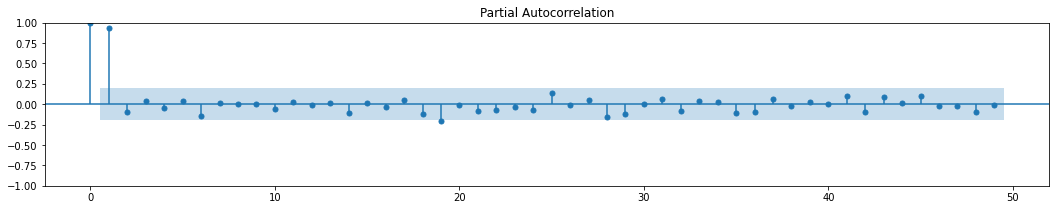

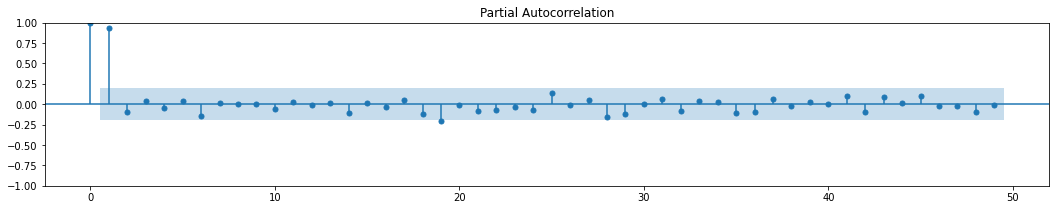

In [60]:
# partial autocorrelation plot of time series as a line plot
plot_pacf(df[-100:], lags=49)

### 移动平均平滑

移动平均平滑是一种简单而有效的时间序列预测技术。它可以用于数据准备、特征工程，甚至直接用于进行预测。平滑是一种应用于时间序列的技术，旨在消除时间步之间的细微变化。平滑的目的是去除噪声，更好地揭示潜在因果过程的信号。

In [61]:
# tail-rolling average transform
rolling = df.rolling(window=3)
rolling_mean = rolling.mean()
rolling_mean.head(10)

Date
2016-01-04       NaN
2016-01-05       NaN
2016-01-06   2006.54
2016-01-07   1983.35
2016-01-08   1951.79
2016-01-11   1929.60
2016-01-12   1928.13
2016-01-13   1917.54
2016-01-14   1916.93
2016-01-15   1897.48
Name: Adj Close, dtype: float64

<AxesSubplot:xlabel='Date'>

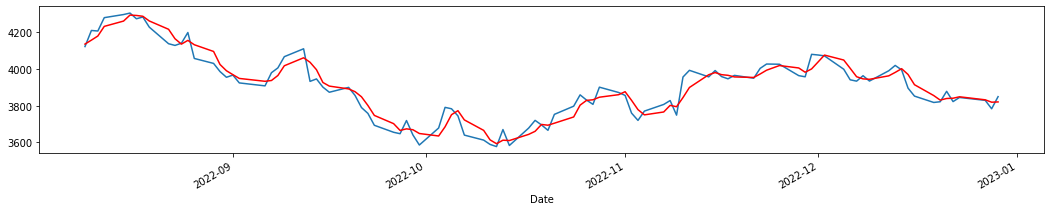

In [62]:
# plot original and transformed dataset
df[-100:].plot()
rolling_mean[-100:].plot(color='red')

### 移动平均作为预测

移动平均值也可以直接用于进行预测。这是一种简单的模型，假设时间序列的趋势和季节性成分已经被去除或调整。移动平均模型用于预测时，可以轻松地以逐步推进的方式使用。随着新观察值的可用（例如，日常数据），模型可以更新，并为下一天做出预测。

In [63]:
# prepare problem
X = df.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [64]:
print('RMSE: %.3f' % rmse)

RMSE: 45.715


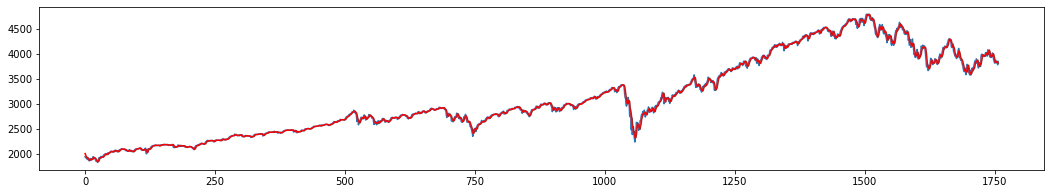

In [65]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

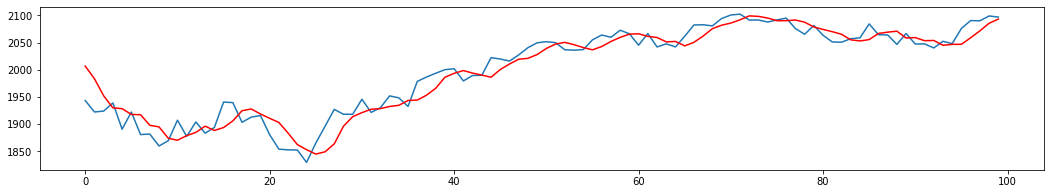

In [66]:
# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show()

### 时间序列组件

选择预测方法的一个有用抽象是将时间序列分解为系统性和非系统性组件。

- **系统性组件**：时间序列中具有一致性或重复性的部分，可以被描述和建模。

- **非系统性组件**：时间序列中无法直接建模的部分。

一个给定的时间序列被认为由三个系统性组件和一个非系统性组件组成，包括水平、趋势、季节性和噪声。各个组件的定义如下：

- **水平**：序列中的平均值。

- **趋势**：序列中持续增加或减少的值。

- **季节性**：序列中重复的短期周期。

- **噪声**：序列中的随机变化。

我们的时间序列数据集可能包含趋势。趋势是指序列随时间的持续增加或减少。识别、建模甚至去除时间序列数据集中的趋势信息可能会带来好处。

时间序列数据集可以包含季节性组件。这是一个随时间重复的周期，例如每月或每年。这个重复的周期可能会掩盖我们在预测时希望建模的信号，并可能为我们的预测模型提供强信号。季节性有很多类型：一天中的时间、每日、每周、每月、每年等。识别时间序列问题中是否存在季节性组件是主观的。确定是否存在季节性最简单的方法是绘制和审查数据，可能在不同的尺度上并添加趋势线。

去除季节性组件的时间序列称为**季节平稳**。如果数据集没有趋势或我们成功去除趋势，则该数据集被称为**趋势平稳**。

### 时间序列数据的平稳性

当数据生成过程的参数随时间不变时，数据被认为是平稳的。

时间序列 $x_t$ 的均值为 $E(x_t)=\mu(t)$

时间序列 $x_t$ 的方差为 $\sigma^2(t)=E[(x_t - \mu(t))^2]$

如果 $\mu(t)=\mu$，即均值随时间保持不变，则时间序列在均值上是平稳的。

如果 $\sigma^2(t)=\sigma^2$,，即方差随时间保持不变，则时间序列在方差上是平稳的。

时间序列如果没有趋势或季节性效应，则被认为是平稳的。对时间序列计算的汇总统计量（如观察值的均值或方差）在时间上是一致的。当时间序列是平稳的时，建模会更容易。

统计建模方法假设或要求时间序列是平稳的，以便有效。许多统计检验在其假设的细则中要求被检验的数据是平稳的。平稳的时间序列（TS）易于预测，因为我们可以假设未来的统计特性与当前的统计特性相同或成比例。

#### 检查平稳性

有多种方法可以检查时间序列（直接观察、残差等）是否平稳或非平稳。

- ***查看图表：*** 您可以查看数据的时间序列图，直观检查是否存在明显的趋势或季节性。

- ***汇总统计：*** 您可以查看数据的汇总统计，按季节或随机分区检查是否存在明显或显著的差异。

- ***统计检验：*** 您可以使用统计检验来检查平稳性期望是否得到满足或是否被违反。

In [67]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

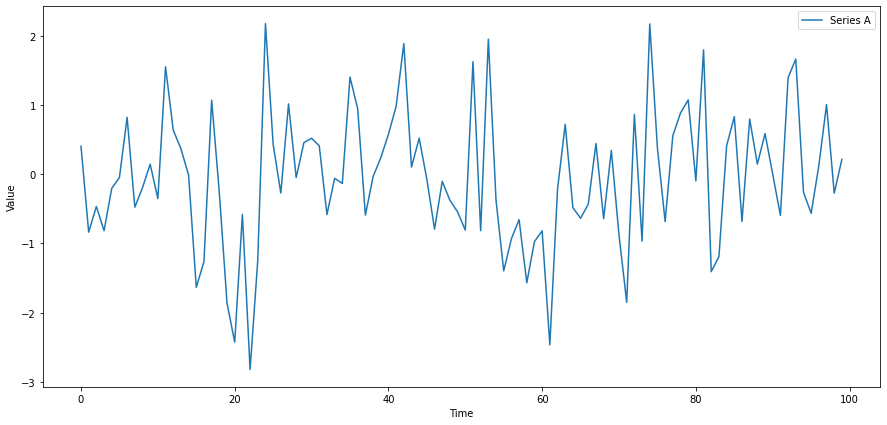

In [68]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A'])
plt.show()

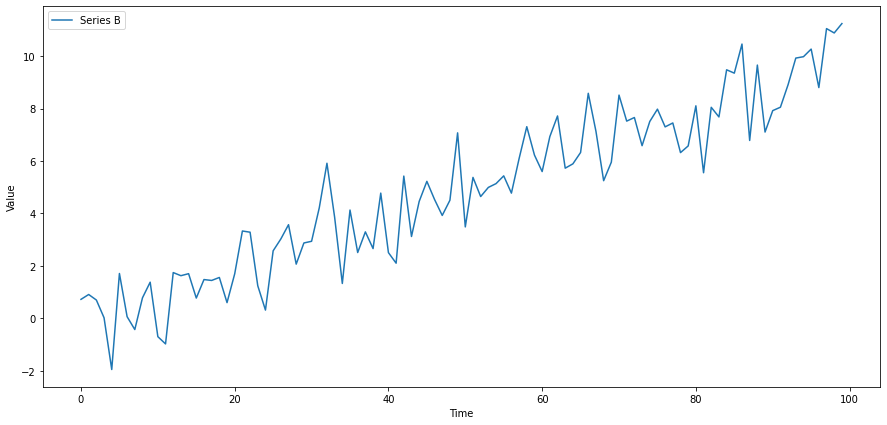

In [69]:
# Set the number of datapoints
T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B'])
plt.show()

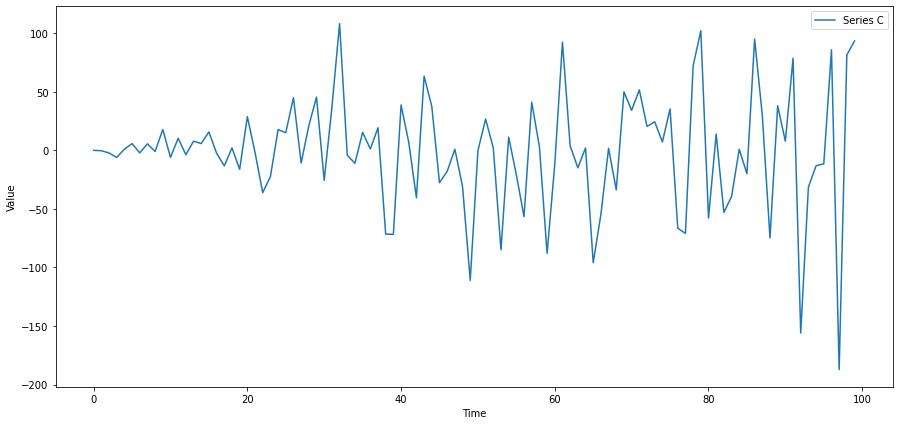

In [71]:
# Set the number of datapoints
T = 100

C = pd.Series(index=range(T))
C.name = 'C'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = ( 0,t * 1)
    C[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C'])
plt.show()

Series A is generated from a stationary process with fixed parameters, series B and C are generated with parameters that change over time.

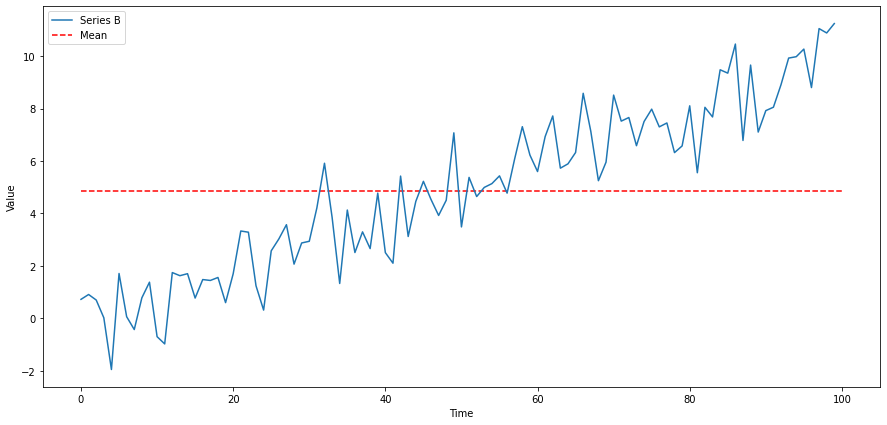

In [72]:
m = np.mean(B)
plt.figure(figsize=(15,7))
plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='r')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])
plt.show()

计算得出的均值将显示截至目前所有数据点的均值，但对于未来状态的预测并没有用处。与任何特定时间相比，这个均值是没有意义的，因为它是不同时间点的不同状态的集合。这只是一个简单明了的例子，说明了非平稳性如何干扰分析，实际上可能会出现更微妙的问题。

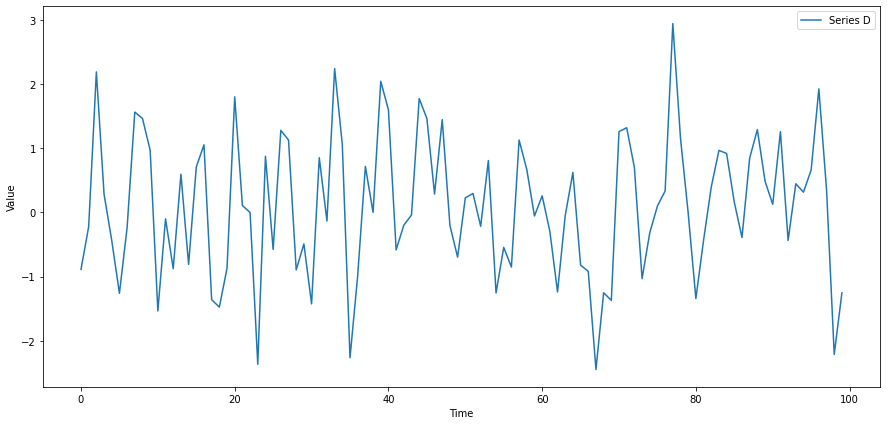

In [73]:
# Set the number of datapoints
T = 100

D = pd.Series(index=range(T))
D.name = 'D'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (np.sin(t), 1)
    D[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(D)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series D'])
plt.show()

均值的周期性波动将很难与随机噪声区分开来。在实际应用中，对于噪声数据和有限样本大小，确定一个序列是否平稳，以及任何漂移是否是随机噪声或趋势的一部分，可能会很困难。在每个具体案例中，测试可能会或可能不会捕捉到这样的微妙效应。

## 增强型迪基-福勒检验

增强型迪基-福勒检验是一种称为单位根检验的统计检验。单位根检验的直觉是确定时间序列在多大程度上由趋势定义。它使用自回归模型，并在多个不同的滞后值上优化信息准则。该检验的原假设是时间序列可以用单位根表示，即它是非平稳的（具有某种时间依赖结构）。备择假设（拒绝原假设）是时间序列是平稳的。

In [84]:
# calculate stationarity test of price data
X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.383278
p-value: 0.590266
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [85]:
# calculate stationarity test of return data
X = Re
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.160572
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


我们可以看到我们的统计值 -14.536258 小于 5% 水平下的临界值 -2.862。这表明我们可以以低于 5% 的显著性水平拒绝原假设（即结果是统计偶然的概率很低）。拒绝原假设意味着该过程没有单位根，进而表明时间序列是平稳的或没有时间依赖结构。

## 协整

现在我们已经讨论了平稳性和积分阶数，我们可以讨论协整。

时间序列的线性组合 ($X_1$, $X_2$, $\dots$, $X_k$) 是一个新的时间序列 $Y$，其构造方式如下，对于任何一组实数 $b_1 \dots b_k$：

$$Y = b_1X_1 + b_2X_2 + \dots + b_kX_k$$

对于某一组时间序列 ($X_1$, $X_2$, $\dots$, $X_k$)，如果所有序列都是 $I(1)$，并且它们的某个线性组合是 $I(0)$，我们称这组时间序列是协整的。

例如，$X_1$、$X_2$ 和 $X_3$ 都是 $I(1)$，而 $2X_1 + X_2 + 0X_3 = 2X_1 + X_2$ 是 $I(0)$。在这种情况下，这些时间序列是协整的。

### 直觉

这里的直觉是，对于某个线性组合，结果缺乏较多的自协方差，主要是噪声。这在配对交易等情况下非常有用，在这种情况下，我们找到两个价格协整的资产。由于它们价格的线性组合 $b_1A_1 + b_2A_2$ 是噪声，我们可以押注于关系 $b_1A_1 + b_2A_2$ 的均值回归，并据此进行交易。

让我们生成一些数据来演示这一点。

In [88]:
# Length of series
N = 100

# Generate a stationary random X1
X1 = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1)
X1.name = 'X1'

# Make an X2 that is X1 plus some noise
X2 = X1 + np.random.normal(0, 1, N)
X2.name = 'X2'

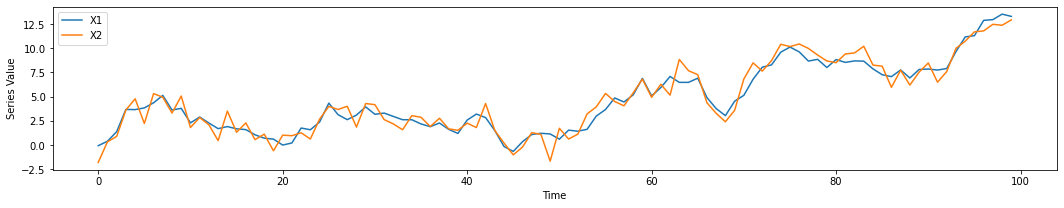

In [89]:
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name])
plt.show()

因为 $X_2$ 只是一个 $I(1)$ 序列加上一些平稳噪声，所以它仍然应该是 $I(1)$。我们来检查一下。现在为了显示协整，我们需要找到 $X_1$ 和 $X_2$ 的某个线性组合是平稳的。我们可以取 $X_2 - X_1$。根据设计，剩下的部分应该是平稳噪声。我们来检查一下。

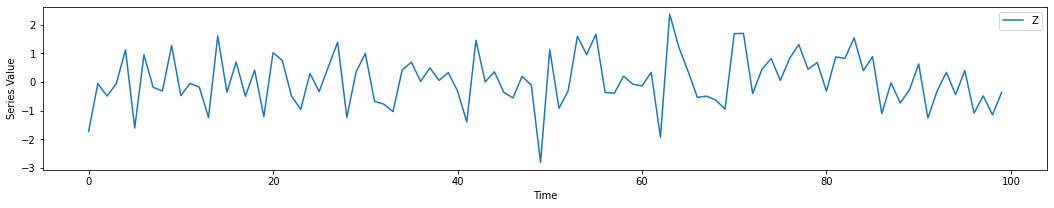

In [90]:
Z = X2 - X1
Z.name = 'Z'

plt.plot(Z)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['Z'])
plt.show()

## 评估模型

时间序列预测的目标是对未来做出准确的预测。我们在机器学习中依赖的快速而强大的方法，例如使用训练-测试拆分和 k 折交叉验证，在时间序列数据的情况下并不适用。这是因为它们忽略了问题中固有的时间成分。

在时间序列预测中，对历史数据进行模型评估称为回测。我们将查看三种不同的方法，您可以使用这些方法在时间序列问题上回测您的机器学习模型：

1. 尊重观察时间顺序的训练-测试拆分。
2. 尊重观察时间顺序的多次训练-测试拆分。
3. 向前验证（Walk-Forward Validation），在每次接收到新数据时可以更新模型。

In [91]:
# calculate a train-test split of a time series dataset
X = Re
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

In [92]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 1760
Training Observations: 1161
Testing Observations: 599


## 持续模型预测

在任何时间序列预测问题中，建立基准是至关重要的。性能基准可以让您了解其他所有模型在您的问题上实际表现如何。在这里，我们将开发一个持续预测模型，稍后可以将其用作该时间序列数据集的基准性能水平。

以下步骤是必需的：

1. 将单变量数据集转换为监督学习问题。
2. 为测试框架建立训练和测试数据集。
3. 定义持续模型。
4. 进行预测并建立基准性能。
5. 回顾完整示例并绘制输出。

In [93]:
# Create lagged dataset
values = pd.DataFrame(Re.values)
Re2 = pd.concat([values.shift(1), values], axis=1)
Re2.columns = ['t', 't+1']
Re2 = Re2[1:]
Re2.head()

,t,t+1
1,0.00,-0.01
2,-0.01,-0.02
3,-0.02,-0.01
4,-0.01,0.00
5,0.00,0.01


In [94]:
# split into train and test sets
X = Re2.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [95]:
# persistence model
def model_persistence(x):
    return x

In [96]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [97]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.017


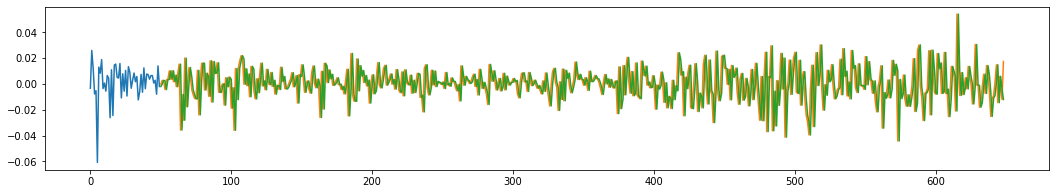

In [98]:
# plot predictions and expected results on the test data
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions])

## 可视化残差预测误差

时间序列预测问题中的预测误差称为残差误差或残差。残差误差的计算方法是将预期结果减去预测值。仔细探索时间序列预测问题上的残差误差可以告诉您很多关于预测模型的信息，甚至可以提出改进建议。

第一个图是查看残差预测误差随时间变化的线图。我们期望该图在 0 的值周围是随机的，并且不显示任何趋势或周期结构。

In [99]:
# calculate residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

<AxesSubplot:>

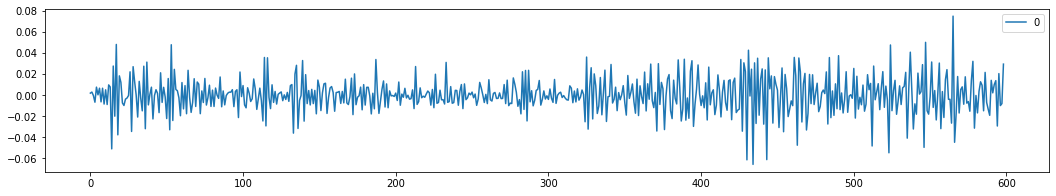

In [100]:
# plot residuals
residuals.plot()

我们可以对残差误差计算汇总统计数据。主要关注的是残差误差的均值。接近零的值表明预测没有偏差，而正值和负值则表明预测存在正偏差或负偏差。了解预测中的偏差是有用的，因为可以在使用或评估预测之前直接对其进行修正。

In [101]:
residuals.describe()

,0
count,599.00
mean,0.00
std,0.02
min,-0.07
25%,-0.01
50%,-0.00
75%,0.01
max,0.07


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

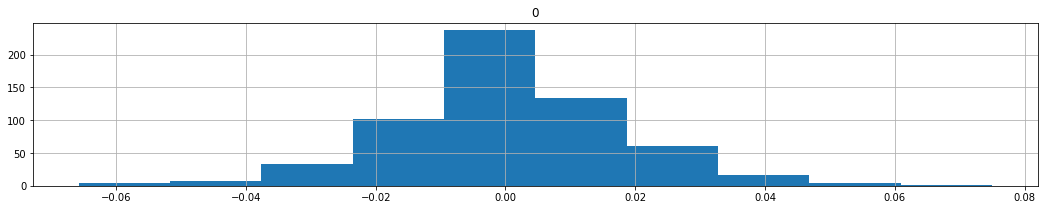

In [102]:
residuals.hist()

<AxesSubplot:ylabel='Density'>

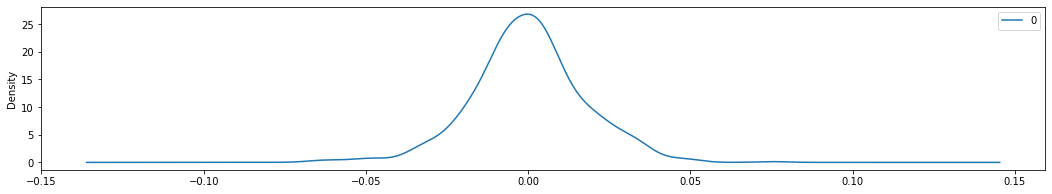

In [103]:
residuals.plot(kind='kde')

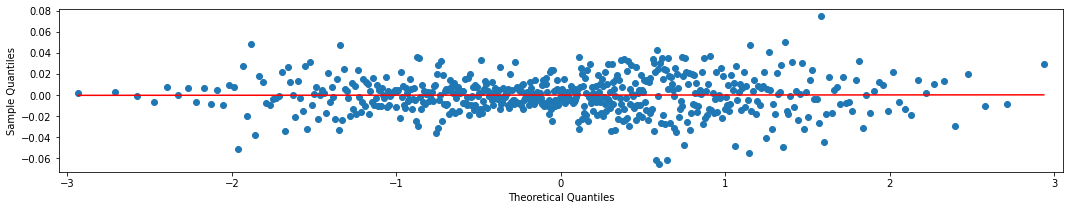

In [104]:
qqplot(residuals, line='r')
plt.show()

### 残差自相关图

我们不希望残差之间存在任何相关性。这将通过自相关得分低于显著性阈值（图中的虚线和点划线）来显示。残差图中的显著自相关表明模型在整合观察值与滞后观察值之间的关系（称为自回归）方面可能做得更好。

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

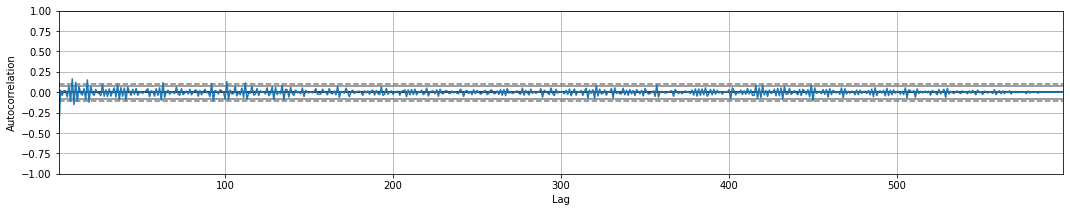

In [105]:
autocorrelation_plot(residuals)

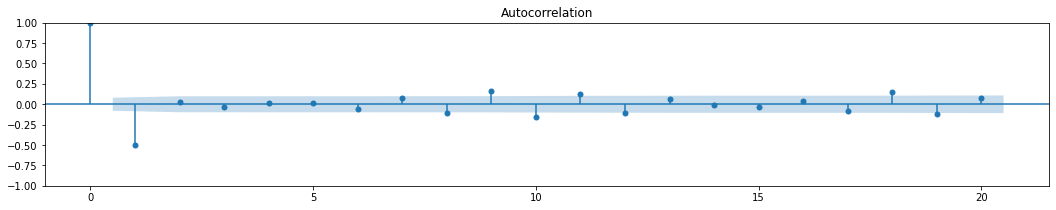

In [106]:
# autocorrelation plot of residuals as a line plot
plot_acf(residuals, lags=20)
plt.show()

## 随机游走

随机游走是一种时间序列模型，其中时间序列变量在每个时间步以相等的概率增加或减少（向上或向下），即当前观察值的期望值等于前一个观察值。它的正式定义如下：

$$x_t = x_{t-1} + w_t$$

其中 $w_t$ 是一个离散白噪声序列。$$E[x_t] = x_{t-1}$$

这意味着如果我们建模的时间序列是随机游走，则它是不可预测的，因为它们确实是随机游走。随机游走的意义在于它是非平稳的，因为虽然随机游走的均值仍然为零，但协方差实际上是时间相关的。特别地，协方差等于方差乘以时间。因此，随着时间的增加，方差也会增加。

让我们模拟一个随机游走。

In [107]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

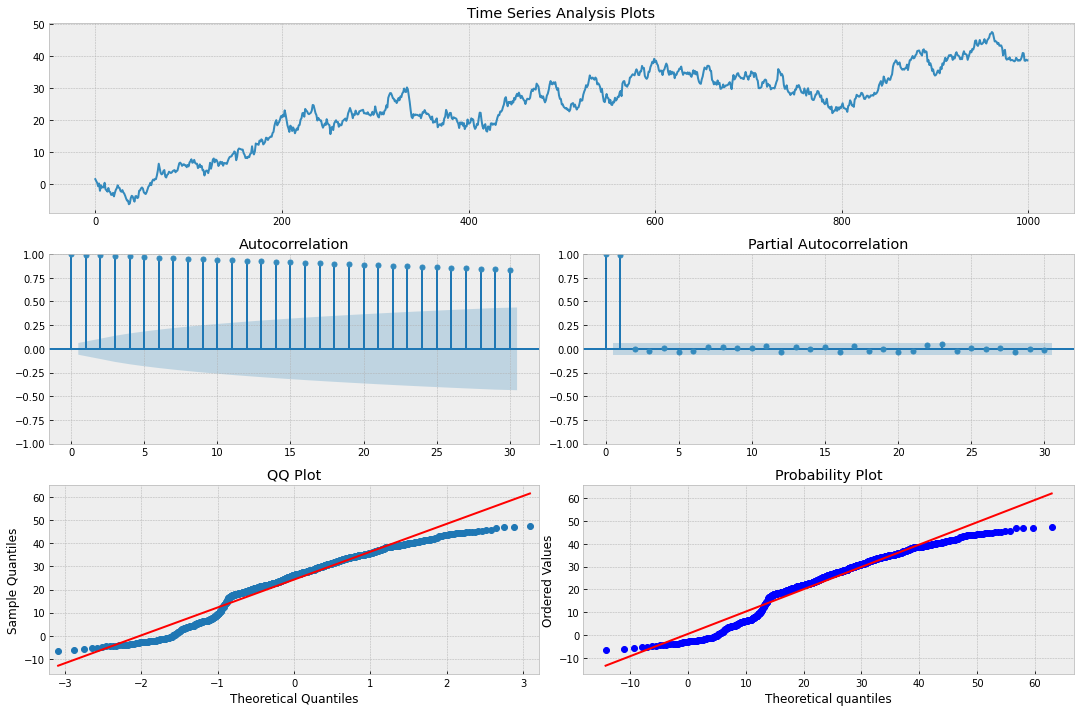

In [108]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

显然，我们的时间序列不是平稳的。如何检查随机游走模型是否适合我们的模拟数据？我们有

$$x_t - x_{t-1} = w_t$$

其中 $w_t$ 是一个离散白噪声序列。我们的随机游走序列的一阶差分应该等于一个白噪声过程！ 

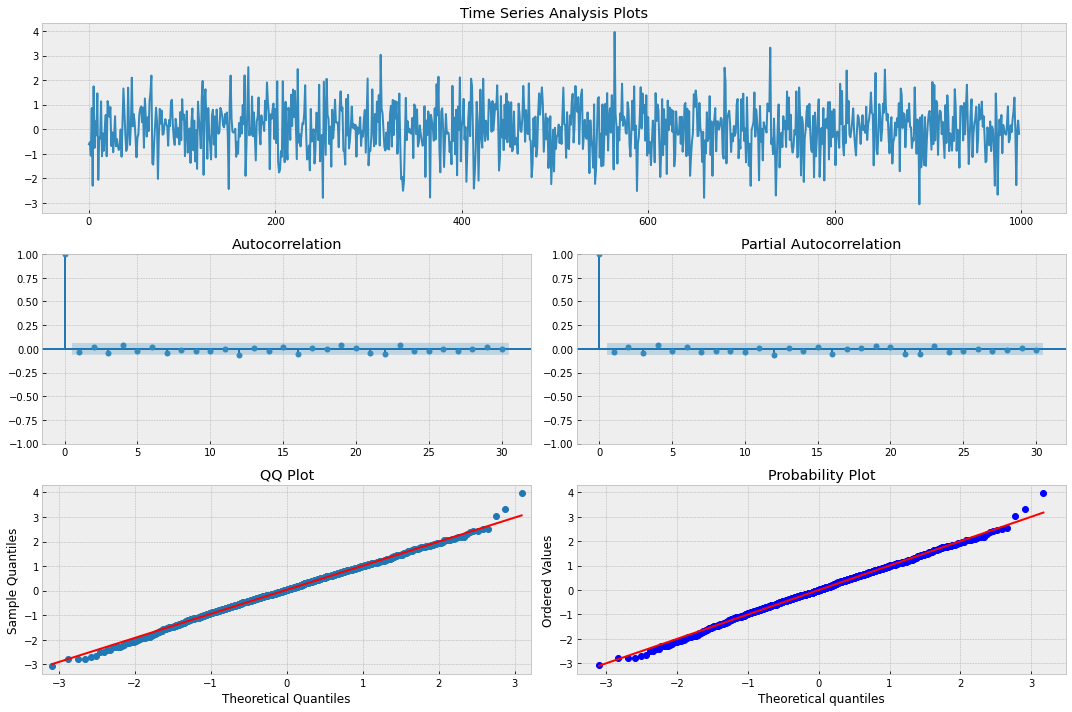

In [109]:
# First difference of simulated Random Walk series
_ = tsplot(np.diff(x), lags=30)

正如预期的那样，差分确实是白噪声。现在让我们将我们的随机游走模型应用于一些实际的金融数据

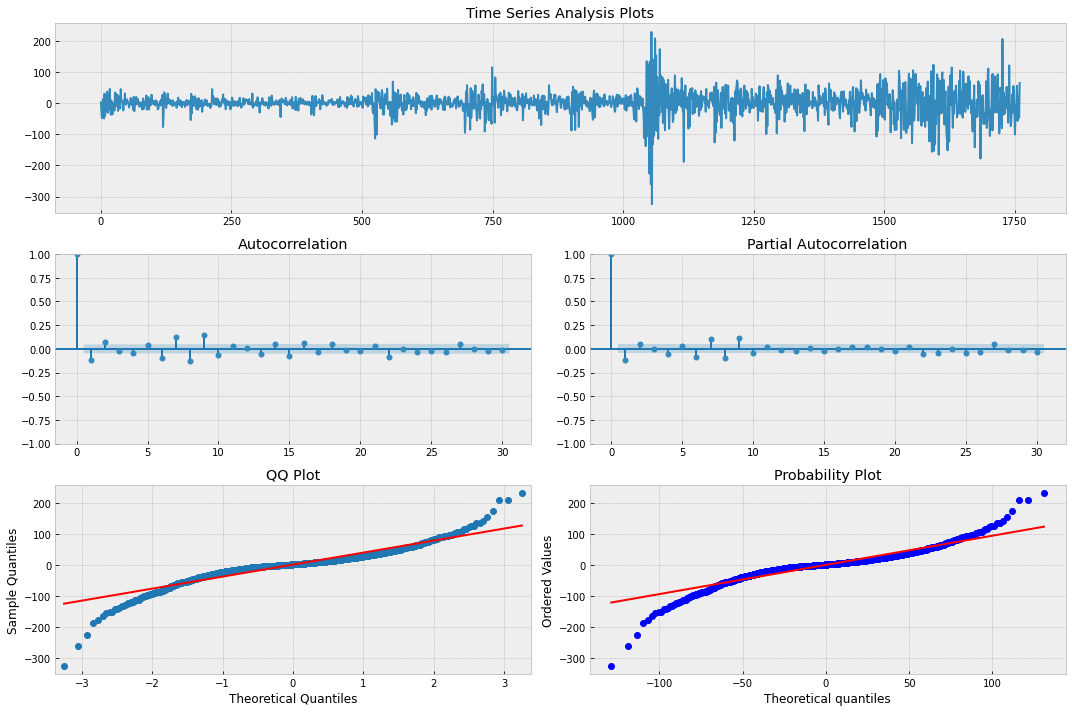

In [110]:
# First difference of SPX prices
_ = tsplot(np.diff(df), lags=30)

确实，它与白噪声非常相似，对吗？然而，在自相关函数（ACF）和偏自相关函数（PACF）图中似乎存在一些显著的序列相关性。此外，请注意 QQ 图和概率图的形状。这表明该过程接近正态分布，但具有“重尾”。这意味着应该有更好的模型来解释标准普尔500指数的价格。

## 线性模型

线性模型，也称为趋势模型，表示可以用直线绘制的时间序列。基本方程为：

$$x_{t} = a_0 + a_1 t + b$$

时间序列的值由系数 $a_0$、$a_1$ 和时间决定。一个例子可以是公司的销售额在每个时间步都以相同的金额增加。以一个假设的例子为例，考虑一家公司的股票价格最初为 100 美元，并且在每个时间步增加 50 美分。

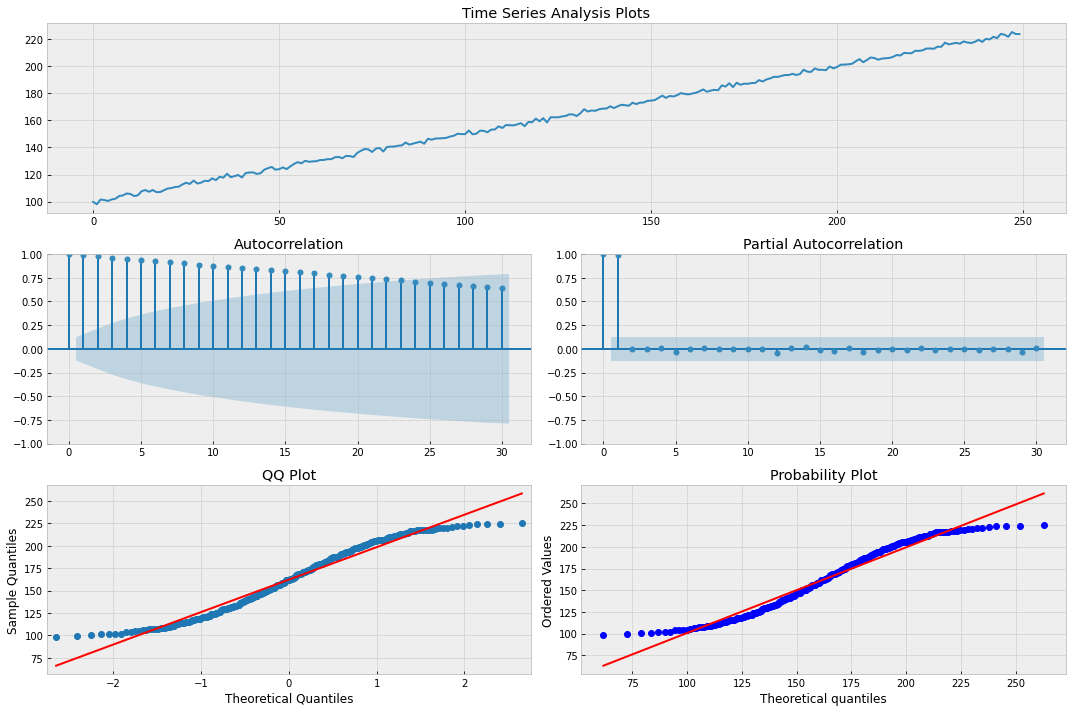

In [111]:
# simulate linear trend

w = np.random.randn(250)
x = np.empty_like(w)

a0 = 100.
a1 = 0.5
for t in range(len(w)):
    x[t] = a0 + a1*t + w[t]
    
_ = tsplot(x, lags=30)

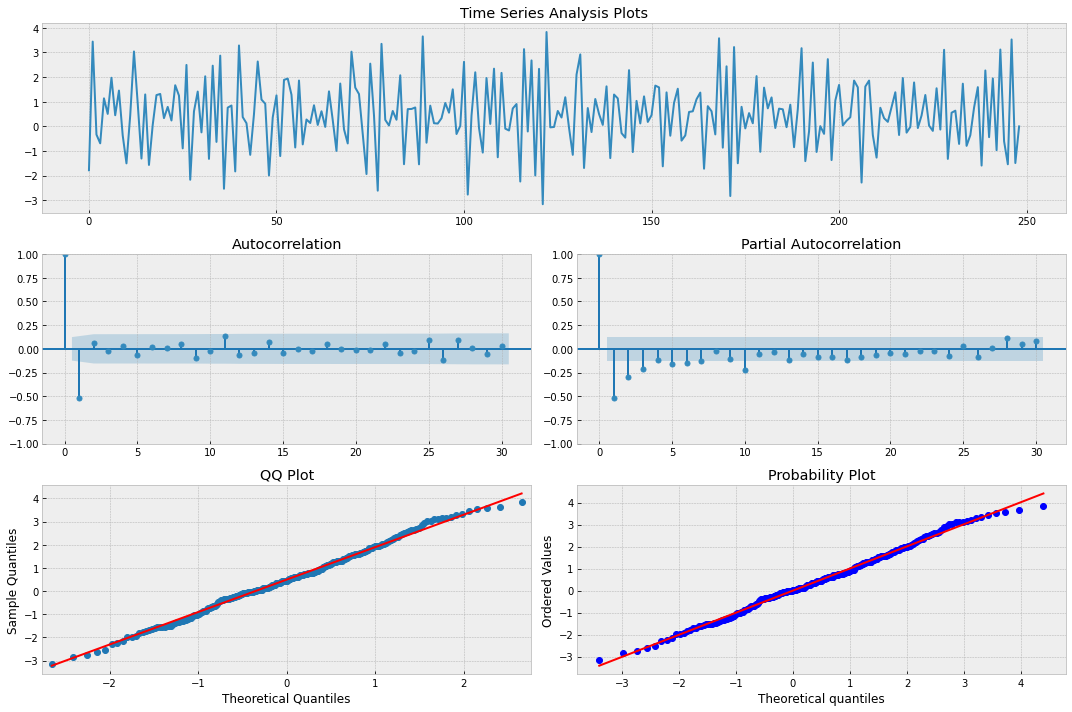

In [113]:
# First difference of simulated prices
_ = tsplot(np.diff(x), lags=30)

在这里，我们可以看到模型的残差是相关的。尽管分布大致呈正态分布，但在使用该模型进行预测之前，我们必须考虑并消除序列中明显的自相关（在滞后 1 处的显著值）。在滞后 1 处的偏自相关函数（PACF）的显著性表明，自回归模型可能是合适的。




使用自回归模型进行预测
自回归是一种时间序列模型，它使用来自前一个时间步的观察值作为回归方程的输入，以预测下一个时间步的值。这是一个非常简单的想法，但在许多时间序列问题上可以产生准确的预测。自回归模型假设当前和前一个时间步的观察值对于预测下一个时间步的值是有用的。

自回归模型是一种线性回归模型，使用滞后变量作为输入变量。Statsmodels 库提供了一个自回归模型，该模型使用统计检验自动选择合适的滞后值，并训练线性回归模型。它在 AR 类中提供

### 自回归模型的阶数 p $AR(p)$

自回归模型实际上是随机游走的扩展。它本质上是一个回归模型，线性依赖于之前的项：

$$x_t = \alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t = \sum_{i=1}^{p} t_i\alpha_ix_{t-i}+w_t$$

这是一个阶数为 "p" 的自回归模型，其中 $p$ 表示模型中使用的前几个（或滞后）项的数量，$\alpha_i$ 是系数，$w_t$ 是白噪声项。请注意，设置 $\alpha_1$ 等于 1 的 AR(1) 模型是一个随机游走！

AR(p) 模型最重要的一个方面是它并不总是平稳的。特定模型的平稳性取决于参数。例如，$\alpha_1$ = 1 的 AR(1) 模型是一个随机游走，因此不是平稳的。

In [114]:
# split dataset
X = Re.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

<AxesSubplot:xlabel='Date'>

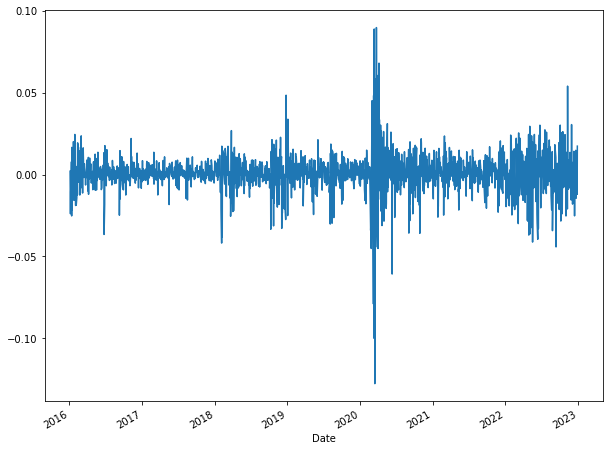

In [115]:
Re.plot(figsize=(10, 8))

In [126]:
max_lag = 30

# Fit the model using AutoReg
model = AutoReg(train, lags=max_lag, trend='n').fit()

# Using the summary, you can visually check the AIC
print(model.summary())

# If you want to programmatically get the AIC value
aic_value = model.aic
print("AIC Value:", aic_value)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1160
Model:                    AutoReg(30)   Log Likelihood                3492.150
Method:               Conditional MLE   S.D. of innovations              0.011
Date:                Tue, 12 Sep 2023   AIC                          -6922.301
Time:                        02:05:57   BIC                          -6766.371
Sample:                            30   HQIC                         -6863.389
                                 1160                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1          -0.1575      0.030     -5.293      0.000      -0.216      -0.099
y.L2           0.0933      0.030      3.102      0.002       0.034       0.152
y.L3           0.0715      0.030      2.371      0.0

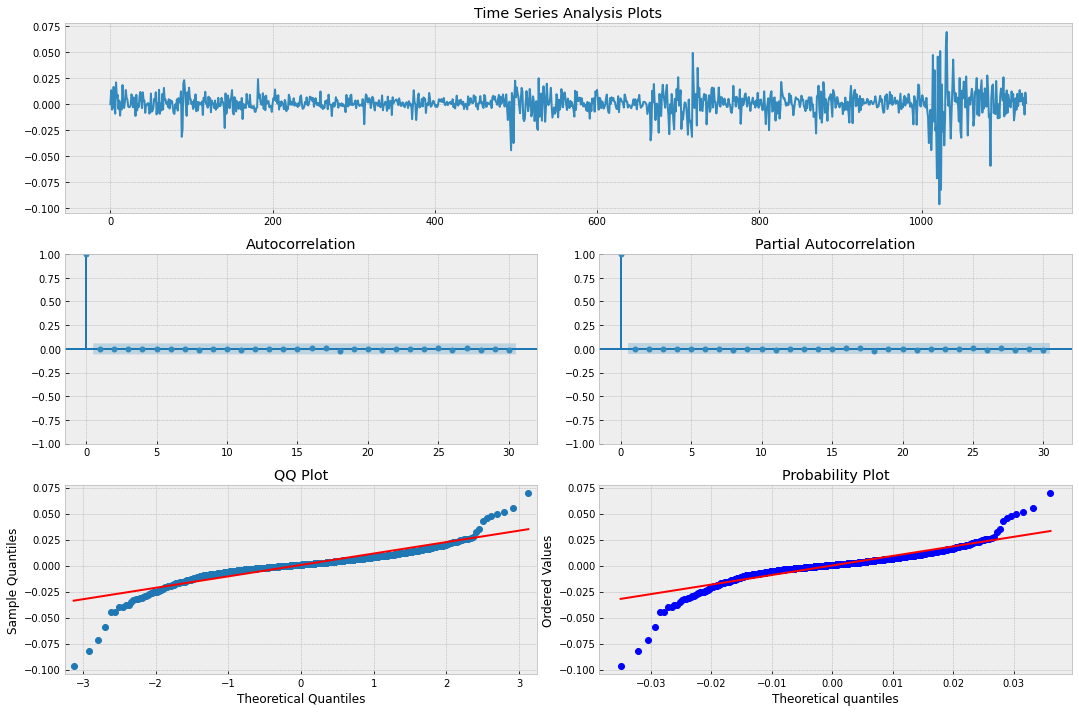

In [123]:
_ = tsplot(model.resid, lags=max_lag)

In [124]:
max_lag = 30
best_aic = np.inf
best_order = 0
best_model = None

# Iterate over multiple lag values
for lag in range(1, max_lag + 1):
    model = AutoReg(train, lags=lag, trend='n').fit()
    if model.aic < best_aic:
        best_aic = model.aic
        best_order = lag
        best_model = model

# Display results
print('Best AR Model Order:', best_order)
print('Best AIC Value:', best_aic)
print(best_model.summary())

Best AR Model Order: 9
Best AIC Value: -7055.463318095056
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1160
Model:                     AutoReg(9)   Log Likelihood                3537.732
Method:               Conditional MLE   S.D. of innovations              0.011
Date:                Tue, 12 Sep 2023   AIC                          -7055.463
Time:                        02:05:00   BIC                          -7004.979
Sample:                             9   HQIC                         -7036.407
                                 1160                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1          -0.1538      0.029     -5.253      0.000      -0.211      -0.096
y.L2           0.0917      0.029      3.110      0.002       0.034       

In [130]:
# Create a 21 day forecast of SPX returns with 95%, 99% CI
n_steps = 21

# Forecast
f = best_model.forecast(steps=n_steps)

# Standard error (assuming normality of residuals)
std_err = best_model.resid.std()

# Confidence intervals for 95% CI
z_95 = 1.96  # For 95% confidence
lower_ci_95 = f - z_95 * std_err
upper_ci_95 = f + z_95 * std_err

# Confidence intervals for 99% CI
z_99 = 2.576  # For 99% confidence
lower_ci_99 = f - z_99 * std_err
upper_ci_99 = f + z_99 * std_err

idx = pd.date_range(df.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame({'forecast': f, 'lower_ci_95': lower_ci_95, 'upper_ci_95': upper_ci_95}, index=idx)
fc_99 = pd.DataFrame({'lower_ci_99': lower_ci_99, 'upper_ci_99': upper_ci_99}, index=idx)

fc_all = fc_95.join(fc_99)
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2022-12-29,0.00,-0.02,0.02,-0.03,0.03
2022-12-30,0.00,-0.02,0.02,-0.03,0.03
2022-12-31,-0.00,-0.02,0.02,-0.03,0.03
2023-01-01,0.00,-0.02,0.02,-0.03,0.03
2023-01-02,-0.00,-0.03,0.02,-0.03,0.03


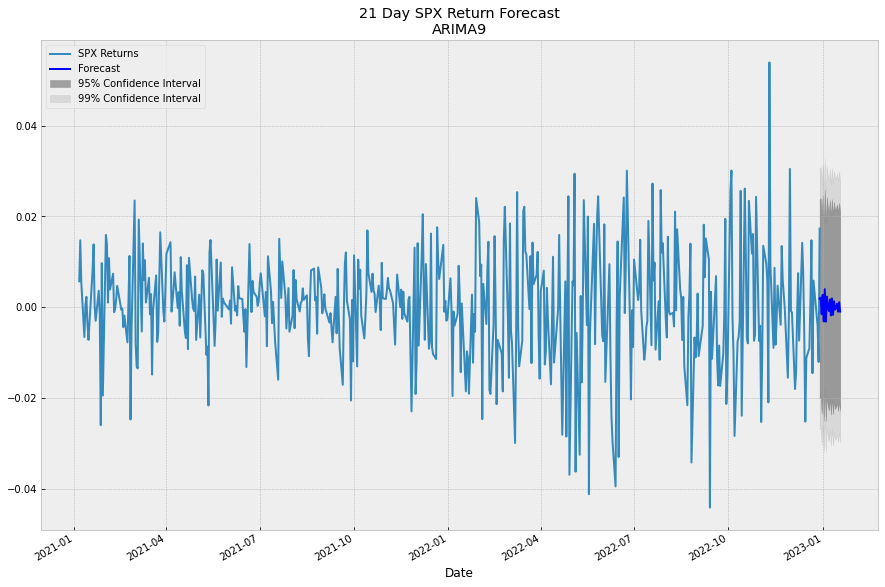

In [132]:
import matplotlib.pyplot as plt

# Set the style
plt.style.use('bmh')

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the last 500 observations of SPX Returns
Re.iloc[-500:].plot(ax=ax, label='SPX Returns')

# Plot the forecast with 95% and 99% confidence intervals
fc_all['forecast'].plot(ax=ax, style='b-', label='Forecast')
ax.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='gray', alpha=0.7, label='95% Confidence Interval')
ax.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='gray', alpha=0.2, label='99% Confidence Interval')

# Set title and labels
ax.set_title('{} Day SPX Return Forecast\nARIMA{}'.format(n_steps, best_order))
ax.legend(loc='best', fontsize=10)

plt.show()

In [135]:
# make predictions
predictions = best_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [136]:
test_period = 7
for i in range(test_period):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test[:test_period], predictions[:test_period]))

predicted=0.001870, expected=-0.000172
predicted=0.002097, expected=0.002706
predicted=-0.001558, expected=0.002301
predicted=0.002705, expected=-0.004414
predicted=-0.003143, expected=0.003154
predicted=0.003958, expected=0.003435
predicted=-0.003205, expected=0.009994


In [137]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.006


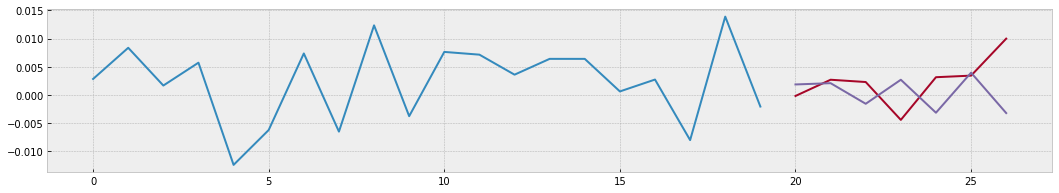

In [138]:
# plot predictions and expected results on the test data
plt.plot(train_y[-20:])
plt.plot([None for i in train_y[-20:]] + [x for x in test_y[:test_period]])
plt.plot([None for i in train_y[-20:]] + [x for x in predictions[:test_period]])

Obviously, we want to rebuild the model after each day as the new data becomes available.

## 向前验证

Statsmodels API 并不容易在新观察值可用时更新模型。一种方法是每天在新观察值可用时重新训练 AR 模型，这可能是一个有效的方法，尽管计算成本较高。另一种选择是使用学习到的系数手动进行预测。这要求保留先前观察值的历史，并从模型中检索系数，然后在回归方程中使用这些系数来得出新的预测。

In [139]:
# split dataset
X = Re.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

In [151]:
# Determine optimal lag based on BIC
best_bic = np.inf
best_lag = None

for lag in range(1, 51):  # assuming a maximum of 50 lags to check
    model = AutoReg(train, lags=lag)
    result = model.fit()
    if result.bic < best_bic:
        best_bic = result.bic
        best_lag = lag

# Fit model using the best lag value
model = AutoReg(train, lags=best_lag)
model_fit = model.fit()

window = len(model_fit.model._lags) # Get the lags used in the model
coef = model_fit.params

In [152]:
# walk forward over time steps in test
history = list(train[-window:])  # last "window" values from the train set

predictions = []

for t in test:
    lag = history[-window:]  # last "window" observations
    yhat = coef[0]  # intercept
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    predictions.append(yhat)
    history.append(t)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE: ', rmse)

RMSE:  0.012456845565257633


In [153]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.012


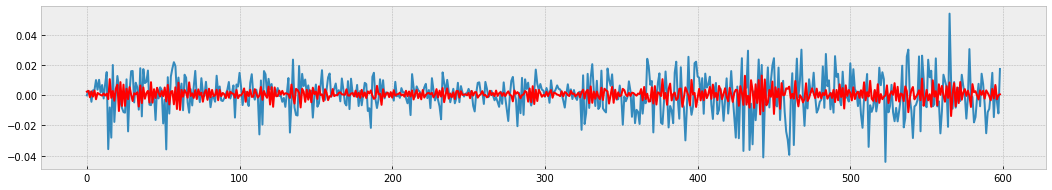

In [154]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')

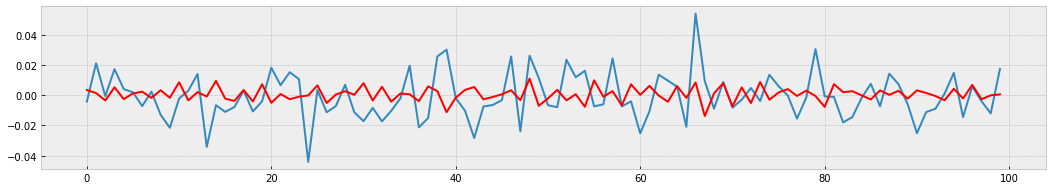

In [155]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

## 移动平均模型用于预测

预期与预测之间的差异称为残差误差。时间序列预测的残差误差提供了另一种可以建模的信息来源。残差误差本身形成一个可以具有时间结构的时间序列。可以使用这种结构的简单自回归模型来预测预测误差，而预测误差又可以用于修正预测。这种类型的模型称为移动平均模型，名称相同但与移动平均平滑有很大不同。

**残差误差的自回归**
我们可以使用自回归模型来建模残差误差时间序列。这是一个线性回归模型，创建滞后残差误差项的加权线性和。
我们可以使用 Statsmodels 库提供的自回归模型（AR）。基于持久性模型（见前一节），我们可以首先在训练数据集上训练计算出的残差误差模型。

- MA 模型的动机在于，我们可以通过将模型拟合到误差项来直接解释误差过程中的“冲击”。（在 AR(p) 模型中，这些冲击是通过使用过去的观察值间接观察到的）

$$x_t=w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$

其中 $w_t$ 是白噪声，$E(w_t)=0$ 且方差为 $\sigma^2$。

根据定义，对于 $k>q$，自相关函数 ACF $ρ_k$ 应该为零。

In [156]:
# create lagged dataset
values = pd.DataFrame(Re.values)
Re3 = pd.concat([values.shift(1), values], axis=1)
Re3.columns = ['t', 't+1']
Re3 = Re3[1:]
Re3.head()

,t,t+1
1,0.00,-0.01
2,-0.01,-0.02
3,-0.02,-0.01
4,-0.01,0.00
5,0.00,0.01


In [157]:
# split into train and test sets
X = Re3.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [158]:
# persistence model on training set
train_pred = [x for x in train_X]

In [159]:
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

In [163]:
# Model the training set residuals
model = AutoReg(train_resid, lags=1)  # You can adjust the number of lags or use methods like BIC/AIC to select the best lag
model_fit = model.fit()
window = len(model_fit.model._lags)  # Get the number of lags used in the model
coef = model_fit.params

In [164]:
print('Lag=%d, Coef=%s' % (window, coef))

Lag=1, Coef=[ 3.45975334e-05 -6.68866643e-01]


自回归模型需要前 17 个时间步的残差误差。因此，我们必须随时保留这些值。当我们逐步通过测试数据集，逐时进行预测和估计误差时，我们可以计算实际的残差误差并更新残差误差时间序列的滞后值（历史），以便我们能够计算下一个时间步的误差。

In [165]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions, expected_error = [], []

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)

    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]

    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    #print('predicted error=%f, expected error=%f' % (pred_error, error))

这是一种向前预测或滚动预测模型。我们最终得到一个来自训练数据集的残差预测误差的时间序列，以及在测试数据集上的预测残差误差。我们可以绘制这些数据，从而快速了解模型在预测残差误差方面的能力。

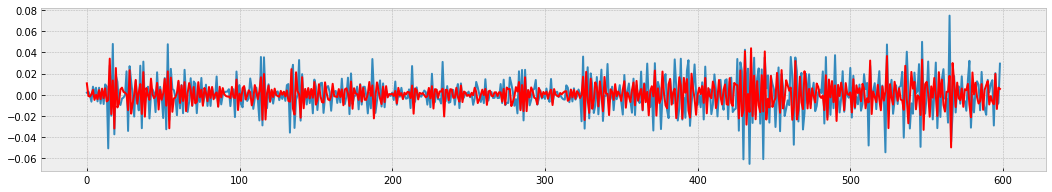

In [166]:
# plot predicted error
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show()

### ARIMA 模型用于预测

自回归积分滑动平均模型（ARIMA）是时间序列预测和分析的标准统计模型。ARIMA 模型是一类用于分析和预测时间序列数据的统计模型。

ARIMA 是自回归积分滑动平均模型的缩写。这个缩写描述了模型本身的关键方面：

- AR：自回归。一个使用观察值与若干滞后观察值之间的依赖关系的模型。
- I：积分。通过对原始观察值进行差分（即从当前观察值中减去前一个时间步的观察值）来使时间序列平稳。
- MA：移动平均。一个使用观察值与应用于滞后观察值的移动平均模型的残差误差之间的依赖关系的模型。

ARIMA 模型的参数定义如下：

- p：包含在模型中的滞后观察值的数量，也称为滞后阶数。
- d：原始观察值进行差分的次数，也称为差分阶数。
- q：移动平均窗口的大小，也称为移动平均阶数。

让我们从简单的开始。我们将为整个洗发水销售数据集拟合一个 ARIMA 模型，并审查残差误差。首先，我们拟合一个 ARIMA(5,1,0) 模型。这将自回归的滞后值设置为 5，使用差分阶数 1 使时间序列平稳，并使用移动平均模型 0。

因此，ARMA 模型在建模金融时间序列时试图捕捉这两个方面。请注意，ARMA 模型不考虑波动聚集，这是许多金融时间序列的一个关键经验现象，我们将在后面讨论。

$$x_t=\alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$

其中 $w_t$ 是白噪声，$E(w_t)=0$ 且方差为 $\sigma^2$。ARMA 模型通常需要的参数比单独的 AR(p) 或 MA(q) 模型要少。也就是说，它在参数上是冗余的。

In [169]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the model
model = ARIMA(Re, order=(5,1,0))
model_fit = model.fit()

In [170]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1760
Model:                 ARIMA(5, 1, 0)   Log Likelihood                5138.319
Date:                Tue, 12 Sep 2023   AIC                         -10264.637
Time:                        02:28:54   BIC                         -10231.802
Sample:                             0   HQIC                        -10252.503
                               - 1760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9696      0.011    -85.159      0.000      -0.992      -0.947
ar.L2         -0.6622      0.017    -38.478      0.000      -0.696      -0.629
ar.L3         -0.4628      0.020    -22.697      0.0

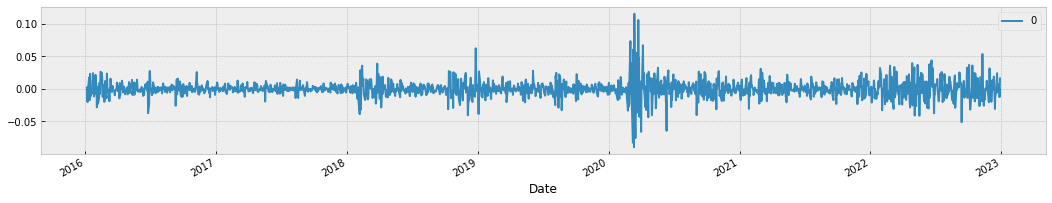

In [171]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

<AxesSubplot:ylabel='Density'>

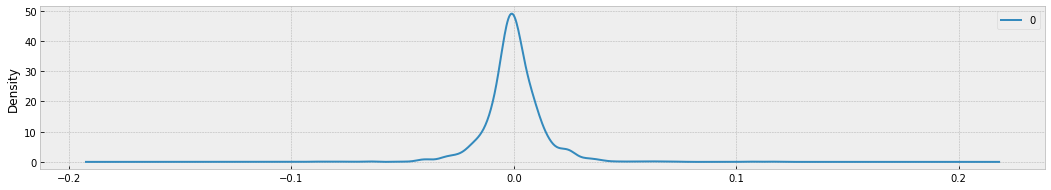

In [172]:
# density plot of residuals
residuals.plot(kind='kde')

In [178]:
# summary stats of residuals
residuals.describe()

,0
count,1760.00
mean,0.00
std,0.01
min,-0.09
25%,-0.01
50%,-0.00
75%,0.01
max,0.12


## 滚动预测 ARIMA 模型

我们可以将训练数据集分为训练集和测试集，使用训练集来拟合模型，并为测试集中的每个元素生成预测。

In [188]:
# split into train and test sets
X = Re.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [190]:
from tqdm import tqdm

# walk-forward validation
total_tests = len(test)

# Using tqdm to wrap the range in order to show a progress bar
for t in tqdm(range(total_tests), desc="Processing", ncols=100):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

Processing: 100%|█████████████████████████████████████████████████| 599/599 [04:09<00:00,  2.40it/s]


In [192]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.014


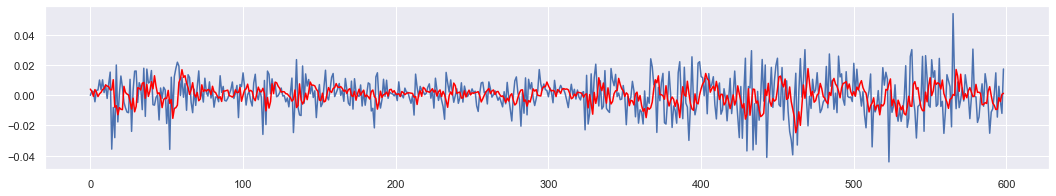

In [193]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red')

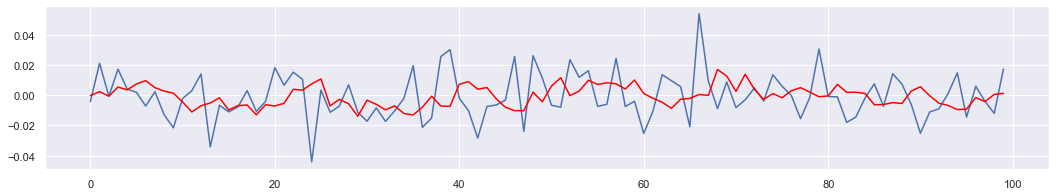

In [194]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

## 网格搜索 ARIMA 模型超参数



In [204]:
from tqdm import tqdm

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = list()
    
    # wrap range with tqdm for progress bar
    for t in tqdm(range(len(test)), desc="Forecasting"):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit() 
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate parameters
p = 3
d = 1
q = 0
order = (p, d, q)
evaluate_arima_model(Re.values, order)

Forecasting: 100%|███████████████████████████████████████████████████████████████████| 599/599 [01:55<00:00,  5.19it/s]


0.01413031589809419

In [207]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]

evaluate_models(Re.values, p_values, d_values, q_values)

## ARCH 和 GARCH 模型

在本节中，我们将讨论条件异方差性，这将引导我们进入第一个条件异方差模型，即 ARCH。然后，我们将讨论 ARCH 的扩展，进而引入著名的广义自回归条件异方差模型，记作 GARCH(p,q)。GARCH 在金融行业中被广泛使用，因为许多资产价格都是条件异方差的。

### 条件异方差性

研究金融中的条件异方差性的主要动机是资产收益的波动性。如果在较大集合中存在某些组或子集的变量，其方差与其余变量不同，则一组随机变量是异方差的。

在金融中，方差的增加可能与进一步的方差增加相关。例如，在股票市场经历大幅下跌的日子，自动风险管理卖出订单会在仅持有多头的投资组合中被触发，这会导致这些投资组合中股票价格的进一步下跌，从而导致显著的向下波动。

这些“抛售”时期以及许多其他形式的波动，导致了序列相关的异方差性，因此在方差增加的时期是有条件的。因此，我们说这样的序列是条件异方差的。

条件异方差序列的一个挑战性方面是，具有波动性的序列的自相关函数（ACF）图可能仍然看起来像是平稳离散白噪声的实现。尽管该序列的方差随时间变化，显然是非平稳的。

为了在我们的模型中纳入条件异方差性（CH），我们可以创建一个利用方差自身的自回归过程的模型——一个实际上考虑到方差随时间变化的模型，使用方差的过去值。这就是自回归条件异方差（ARCH）模型的基础。

### 自回归条件异方差模型 - ARCH(p)

ARCH(p) 模型可以被视为简单地将 AR(p) 模型应用于时间序列的方差。
$$Var(\epsilon_t) = \alpha_0 + \alpha_1Var(\epsilon_{t-1})+…+\alpha_pVar(\epsilon_{t-p})+w_t$$
实际的时间序列为：
$$\epsilon_t = w_t\sqrt{\alpha_0 + \alpha_1\epsilon_{t-1}^2+…+\alpha_p\epsilon_{t-p}^2}$$
对于 ARCH(1)，这可以表示为：
$$\epsilon_t = w_t\sqrt{\alpha_0+\alpha_1\epsilon_{t-1}^2}$$

### 何时应用 ARCH(p)？

当我们尝试拟合 AR(p) 模型并关注序列的 ACF 图中 $p$ 滞后的衰减时，我们可以将相同的逻辑应用于残差的平方。如果我们发现可以将 AR(p) 应用于这些平方残差，那么我们就有迹象表明 ARCH(p) 过程可能是合适的。

请注意，ARCH(p) 应仅应用于已经拟合了适当模型的序列，以使残差看起来像离散白噪声。由于我们只能通过平方残差并检查 ACF 来判断 ARCH 是否合适，因此我们还需要确保残差的均值为零。

ARCH 应仅应用于没有任何趋势或季节效应的序列，即没有（明显的）序列相关性。ARIMA 通常应用于这样的序列，此时 ARCH 可能是一个合适的选择。

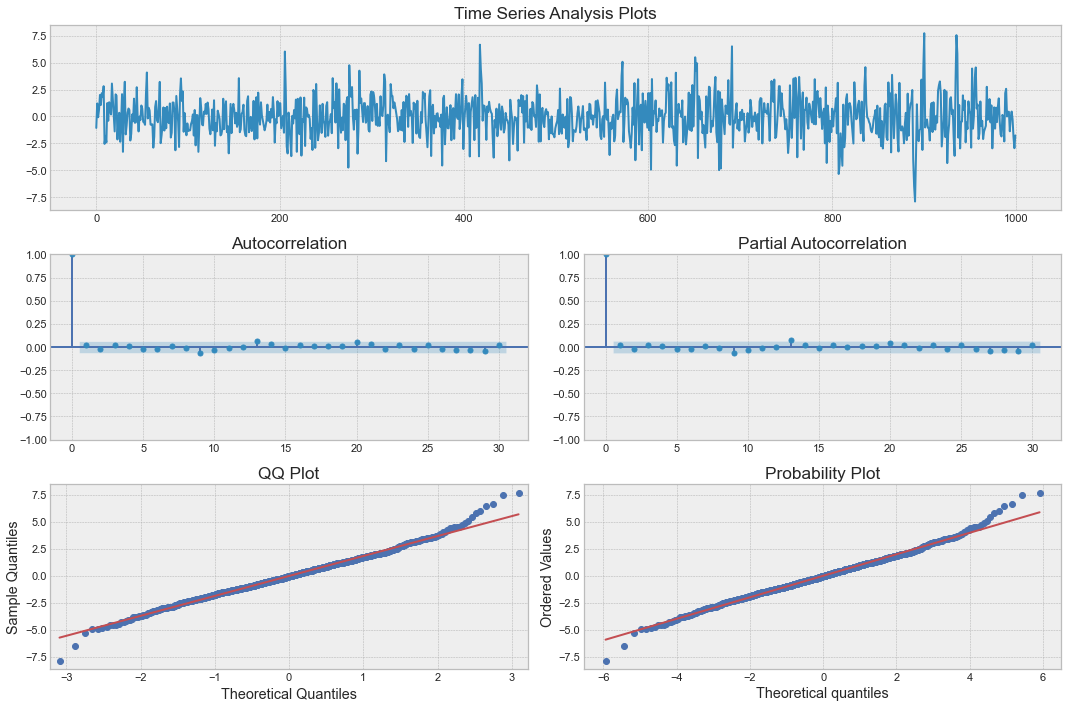

In [209]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(y, lags=30)

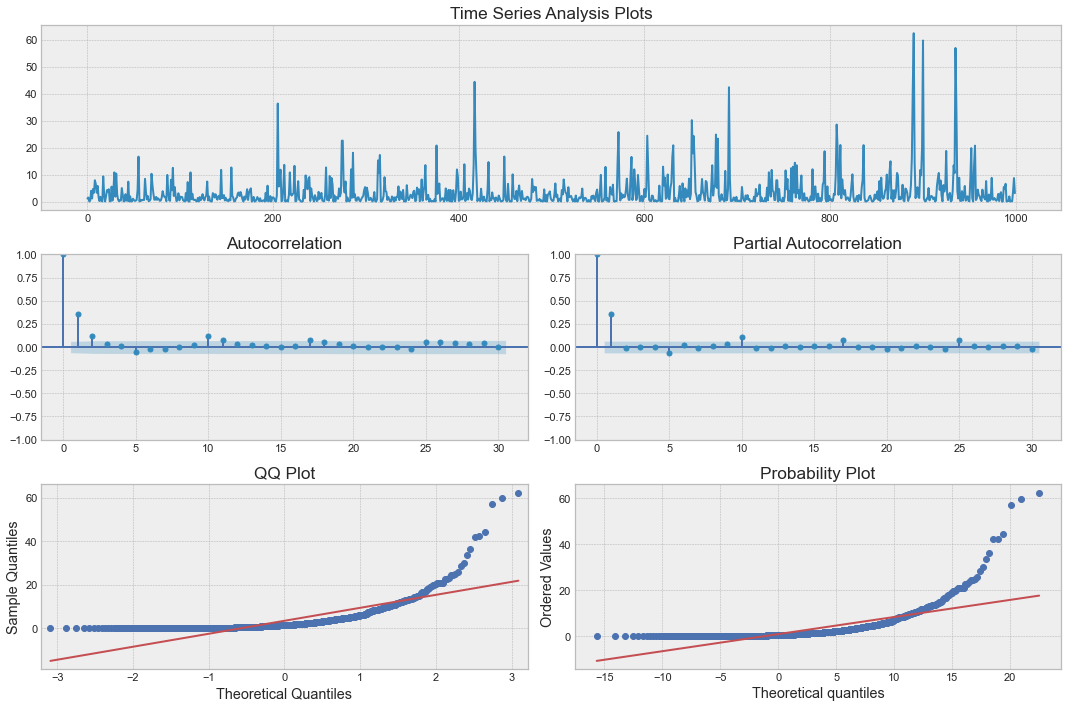

In [210]:
tsplot(y**2, lags=30)

注意到时间序列看起来就像白噪声。然而，当我们绘制该序列的平方时，ACF 和 PACF 似乎在滞后 1 处显示出显著性，表明方差的 AR(1) 模型可能是合适的。

在这个阶段，一个显而易见的问题是，如果我们要将 AR(p) 过程应用于方差，为什么不同时应用移动平均 MA(q) 模型呢？或者使用混合模型，如 ARMA(p,q)？这实际上是广义 ARCH 模型（GARCH）的动机。

### 广义自回归条件异方差模型 - GARCH(p,q)

GARCH(p, q) 是一个应用于时间序列方差的 ARMA 模型，即它具有自回归项和移动平均项。AR(p) 模型用于残差（平方误差）的方差，或者简单地说是我们时间序列的平方。MA(q) 部分则建模该过程的方差。

$$\epsilon_t = \sigma_t w_t$$

其中 $w_t$ 是离散白噪声，均值为零，方差为 1，而 $\sigma^2$ 由以下公式给出：

$$\sigma_t^2=\alpha_0+\sum_{i=1}^{p}\alpha_i\epsilon_{t-i}^2+\sum_{j=1}^{q}\beta_j\sigma_{t-j}^2$$

其中 $\alpha_i$ 和 $\beta_j$ 是模型的参数。对于 GARCH(1,1)，$\sigma^2$ 为：

$$\sigma_t^2=\alpha_0+\alpha_1\epsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$

要求 $\alpha_1 + \beta_1$ 必须小于 1，否则模型将不稳定。我们可以在下面模拟一个 GARCH(1, 1) 过程。

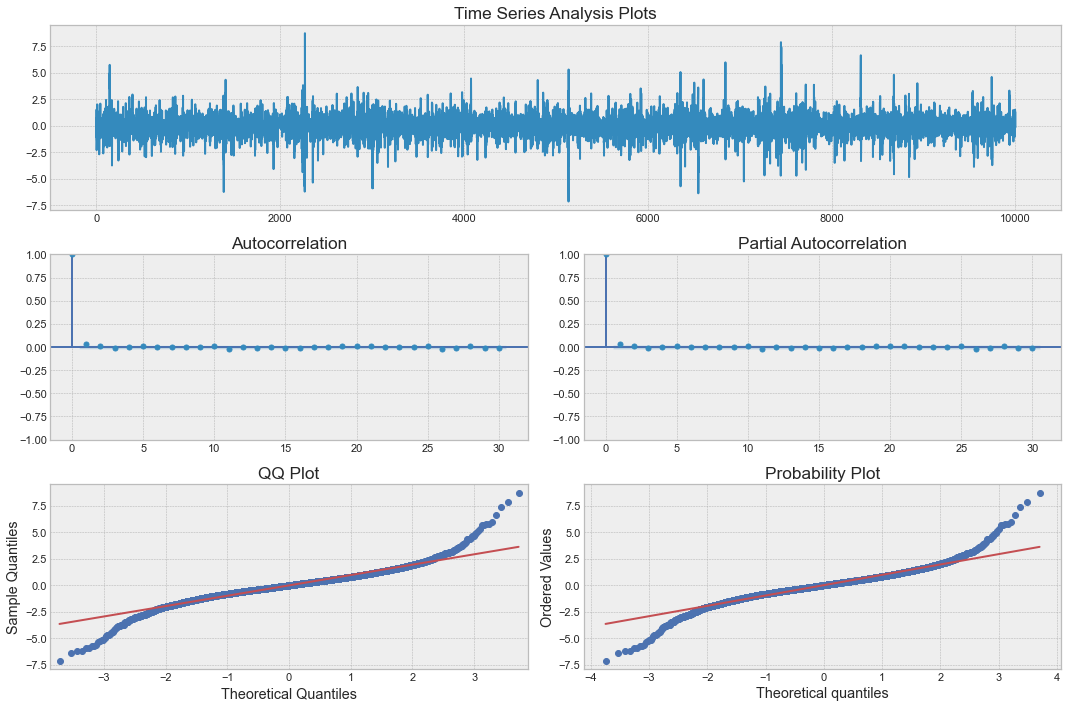

In [211]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

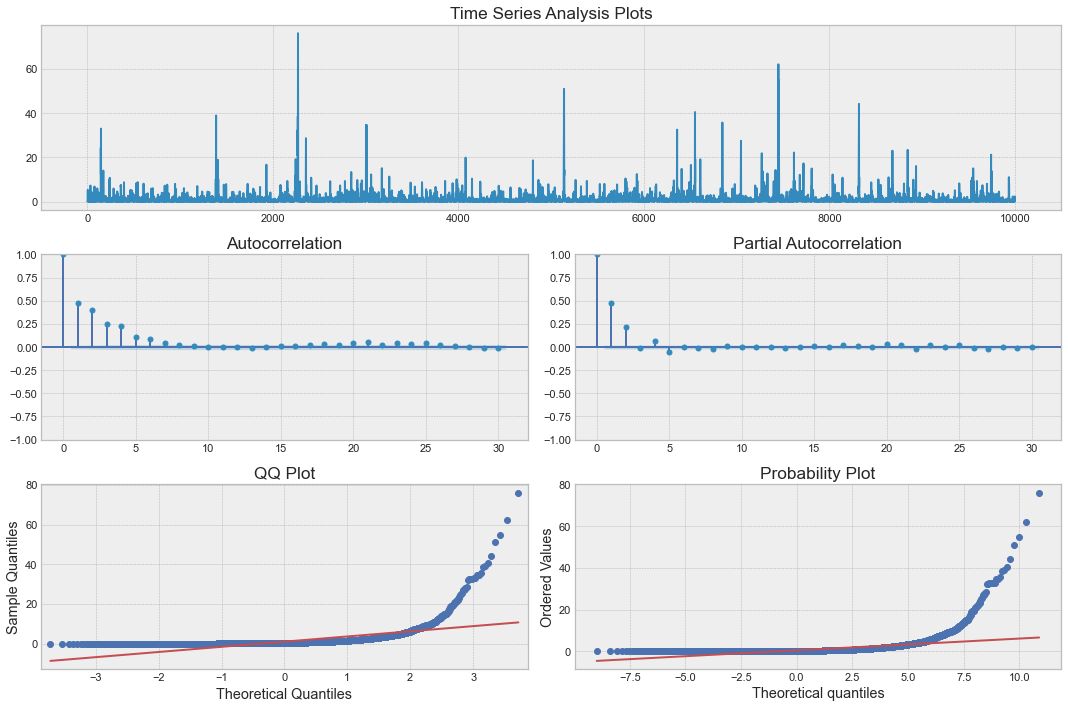

In [212]:
_ = tsplot(eps**2, lags=30)

In [214]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

#! pip install arch
from arch import arch_model

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13129.790134449831
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12237.312781716888
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12237.303267318712
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Tue, Sep 12 2023   Df Residuals:                     9999
Time:       

### 应用到金融时间序列

现在将该过程应用于金融时间序列。我们将使用 SPX 收益。过程如下：

1. 迭代 ARIMA(p, d, q) 模型的组合，以最佳拟合我们的时间序列。
2. 根据具有最低 AIC 的 ARIMA 模型选择 GARCH 模型的阶数。
3. 将 GARCH(p, q) 模型拟合到我们的时间序列。
4. 检查模型残差和平方残差的自相关性。

在这里，我们首先尝试将 SPX 收益拟合到 ARIMA 过程，并找到最佳阶数。

In [215]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = Re
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)
res_tup = _get_best_model(TS)

aic:    inf | order: None


In [59]:
order = res_tup[1]
model = res_tup[2]

由于我们已经对收益进行了对数处理，因此我们应该期望我们的积分成分 \(d\) 等于零，实际上确实如此。我们发现最佳模型是 ARIMA(4,0,3)。现在我们绘制残差，以判断它们是否具有条件异方差行为的证据。

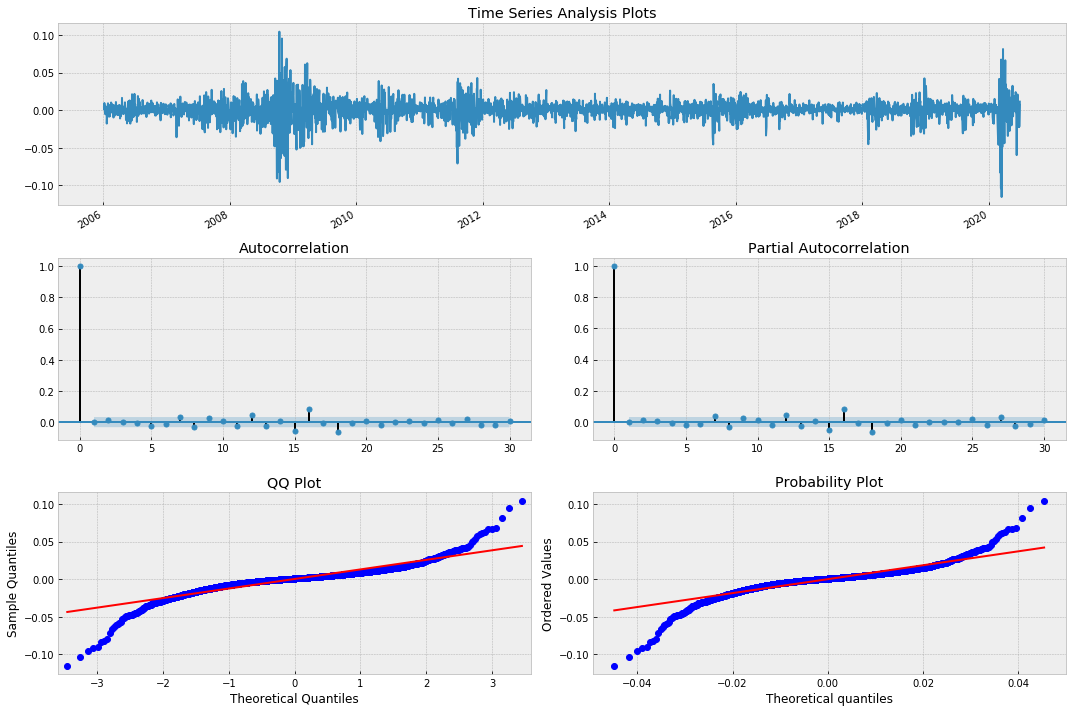

In [60]:
tsplot(model.resid, lags=30)

我们发现残差看起来像白噪声。接下来，我们来查看残差的平方。

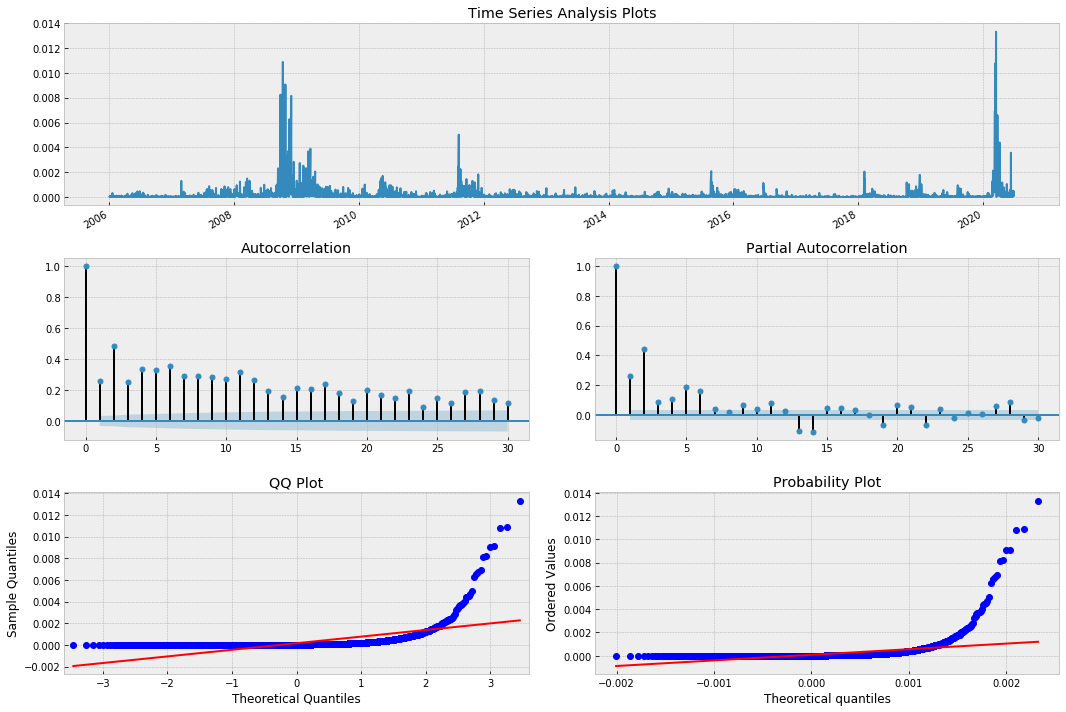

In [61]:
tsplot(model.resid**2, lags=30)

我们可以清楚地看到平方残差中存在自相关的证据。接下来，让我们拟合一个 GARCH 模型，看看它的表现如何。

In [78]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = order[0]
o_ = order[1]
q_ = order[1]

# Using student T distribution usually provides better fit
am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -0.171
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.171
Vol Model:                             ARCH   Log-Likelihood:                9907.53
Distribution:      Standardized Student's t   AIC:                          -19801.1
Method:                  Maximum Likelihood   BIC:                          -19757.6
                                              No. Observations:                 3646
Date:                      Mon, Jan 25 2021   Df Residuals:                     3639
Time:                              07:48:28   Df Model:                            7
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


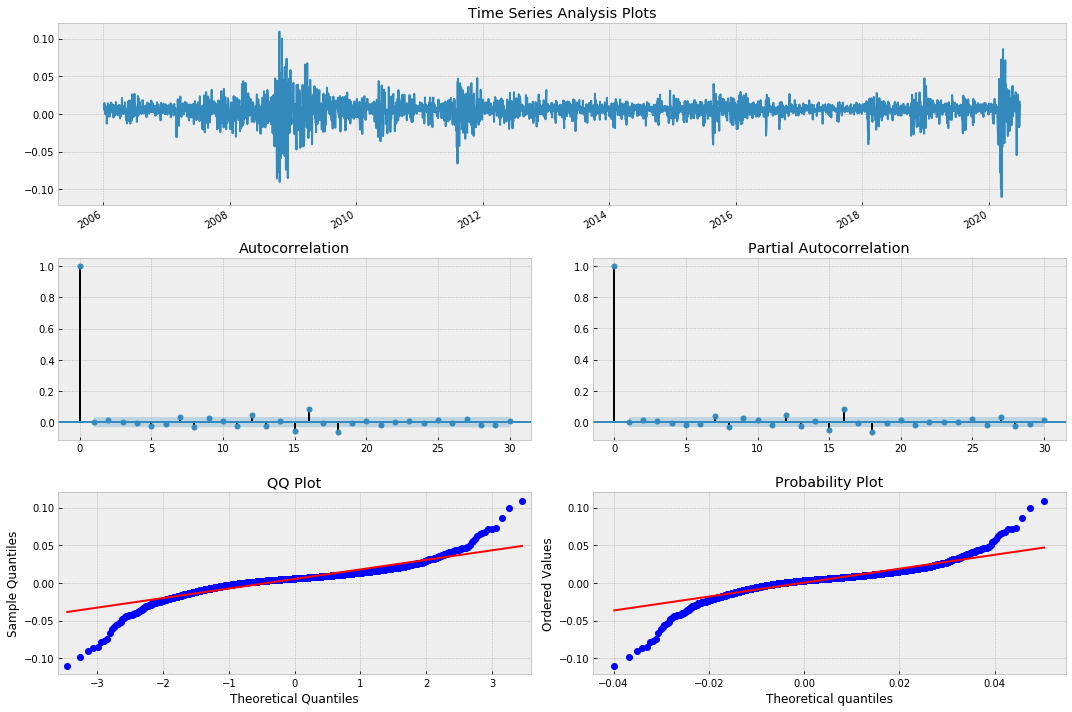

In [79]:
tsplot(res.resid, lags=30)

这些图看起来像是离散白噪声过程的实现，表明拟合效果良好。接下来，我们绘制残差的平方以确认这一点。

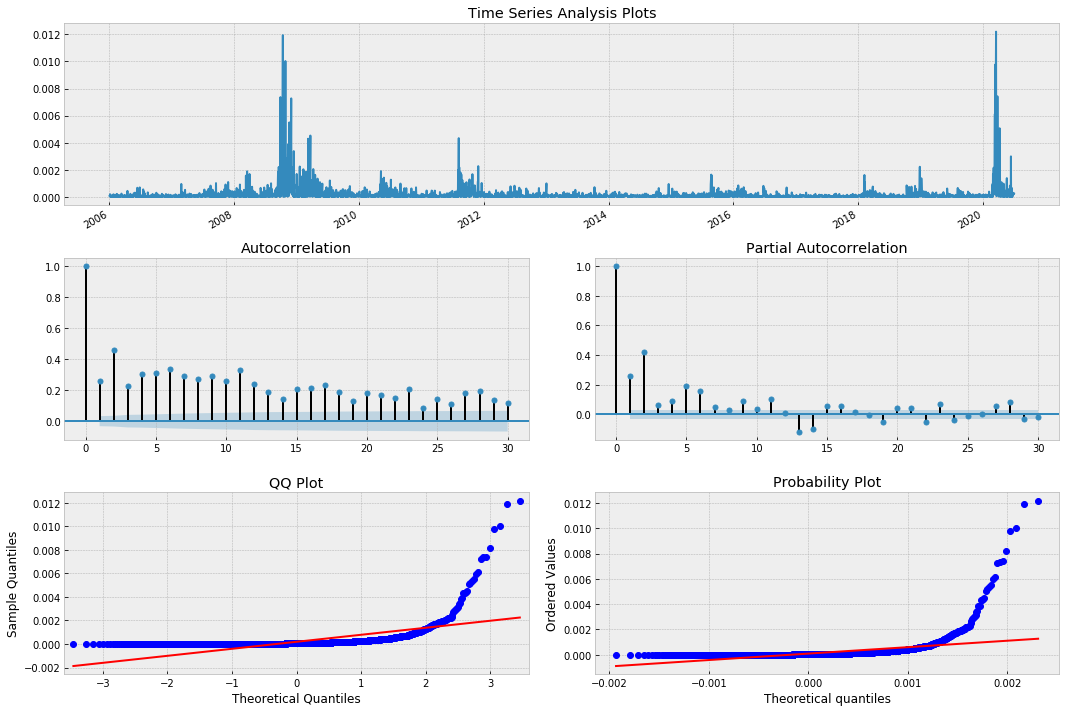

In [80]:
tsplot(res.resid**2, lags=30)

## S&P 500 指数的 ARIMA+GARCH 交易策略


## 策略概述

该策略的思路如下：

- 对于每一天 \(n\)，使用 S&P 500 在前 \(k\) 天的差分对数收益来拟合一个最优的 ARIMA 和 GARCH 模型。

- 使用组合模型对下一天的收益进行预测。

- 如果预测为正，则在第 \(n\) 天的收盘时做多该股票；如果预测为负，则做空该股票。

- 如果预测与前一天相同，则不采取任何行动。

我们将使用 \(k=500\)，但这个参数可以进行优化，以提高性能或减少回撤。

**注意：回测未考虑佣金或滑点，因此在实际交易系统中实现的性能将低于您在此处看到的结果。**

### 策略实施

In [81]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [82]:
# load dataset
start = datetime.datetime(2006,1,1)
end = datetime.datetime(2020,6,30)
df = yf.download("^GSPC", start=start, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [85]:
# display first few lines of a time series
df.head()

Date
2006-01-03   1268.80
2006-01-04   1273.46
2006-01-05   1273.48
2006-01-06   1285.45
2006-01-09   1290.15
Name: Adj Close, dtype: float64

In [88]:
# log returns
lrets = np.log(df/df.shift(1)).fillna(0)
lrets.index = pd.DatetimeIndex(lrets.index.values,freq=lrets.index.inferred_freq)

In [89]:
lrets.head()

2006-01-03   0.00
2006-01-04   0.00
2006-01-05   0.00
2006-01-06   0.01
2006-01-09   0.00
Name: Adj Close, dtype: float64

In [90]:
windowLength = 252
foreLength = len(lrets) - windowLength

In [91]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(1,4) # [1,2,3]
    for i in pq_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,0,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, 0, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: %6.5f | order: %s'%(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

在这个阶段，我们需要遍历交易数据中的每一天，并为长度为 \(k=500\) 的滚动窗口拟合适当的 ARIMA 和 GARCH 模型。考虑到我们尝试 32 种不同的 ARIMA 拟合，并为每一天拟合一个 GARCH 模型，因此生成该指标可能需要较长的时间。 


In [ ]:
signal = 0*lrets[-foreLength:]
for d in range(foreLength):
    # create a rolling window by selecting the values between 1+d and k+d of S&P500 returns
    TS = lrets[(1+d):(windowLength+d)] 
    # Find the best ARIMA fit (we set differencing to 0 since we've already differenced the series once)
    res_tup = _get_best_model(TS)
    order = res_tup[1]
    model = res_tup[2]
    #now that we have our ARIMA fit, we feed this to GARCH model
    p_ = order[0]
    o_ = order[1]
    q_ = order[2]

    am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')
    out = res.forecast(horizon=1, start=None, align='origin')
    signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])

### 策略结果

现在我们已经生成了交易信号，接下来需要将其表现与“买入并持有”策略进行比较。

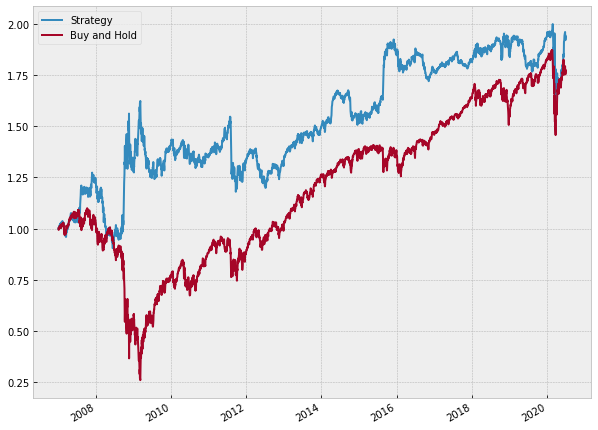

In [106]:
rets = pd.DataFrame(index = signal.index, columns=['Buy and Hold', 'Strategy'])
rets['Buy and Hold'] = lrets[-foreLength:]
rets['Strategy'] = signal
rets['Strategy'] = rets['Strategy']*rets['Buy and Hold']

eqCurves = pd.DataFrame(index = signal.index, columns=['Buy and Hold', 'Strategy'])
eqCurves['Buy and Hold']=rets['Buy and Hold'].cumsum()+1
eqCurves['Strategy'] = rets['Strategy'].cumsum()+1
eqCurves['Strategy'].plot(figsize=(10,8))
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()